In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-v0_8-notebook')

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
from keras.losses import MeanSquaredError

In [2]:
# mengambil lokasi file dataset
link = 'https://raw.githubusercontent.com/Pixel4bit/Data-BMKG/main/Raw_Dataset_BMKG_2013_2024_Jakarta_Pusat.csv'

# membaca file dataset dan menampilkan dataset dalam bentuk tabel atau dataframe
climate_data = pd.read_csv(link)
climate_data

Tanggal    Tn    Tx  Tavg  RH_avg     RR   ss  ff_x  ff_avg
0     01/01/2013  24.0  31.8  26.2    91.0    1.7  3.5   6.0     3.0
1     02/01/2013  25.0  31.4  27.9    79.0    0.0  1.2   4.0     3.0
2     03/01/2013  26.0  32.6  28.6    79.0    1.3  3.5   5.0     4.0
3     04/01/2013  25.0  30.2  26.3    86.0   34.4  0.4   9.0     5.0
4     05/01/2013  24.0  30.8  26.6    82.0    6.4  4.8   7.0     4.0
...          ...   ...   ...   ...     ...    ...  ...   ...     ...
4044  28/01/2024  25.0  30.6  27.4    85.0   28.0  0.0   5.0     1.0
4045  29/01/2024   NaN  29.8  27.2    88.0   24.0  1.2   5.0     1.0
4046  30/01/2024  24.6  32.8  26.9    88.0   17.6  0.8   5.0     1.0
4047  31/01/2024  25.0  31.4  27.9    81.0  110.5  0.7   4.0     1.0
4048  01/02/2024  25.0  31.6  27.8    83.0    0.0  2.2   7.0     1.0

[4049 rows x 9 columns]

# **Preprocessing Data**

In [3]:
# merubah format tanggal dataset agar sesuai
climate_data['Tanggal'] = pd.to_datetime(climate_data['Tanggal'], format='%d/%m/%Y')
climate_data

Tanggal    Tn    Tx  Tavg  RH_avg     RR   ss  ff_x  ff_avg
0    2013-01-01  24.0  31.8  26.2    91.0    1.7  3.5   6.0     3.0
1    2013-01-02  25.0  31.4  27.9    79.0    0.0  1.2   4.0     3.0
2    2013-01-03  26.0  32.6  28.6    79.0    1.3  3.5   5.0     4.0
3    2013-01-04  25.0  30.2  26.3    86.0   34.4  0.4   9.0     5.0
4    2013-01-05  24.0  30.8  26.6    82.0    6.4  4.8   7.0     4.0
...         ...   ...   ...   ...     ...    ...  ...   ...     ...
4044 2024-01-28  25.0  30.6  27.4    85.0   28.0  0.0   5.0     1.0
4045 2024-01-29   NaN  29.8  27.2    88.0   24.0  1.2   5.0     1.0
4046 2024-01-30  24.6  32.8  26.9    88.0   17.6  0.8   5.0     1.0
4047 2024-01-31  25.0  31.4  27.9    81.0  110.5  0.7   4.0     1.0
4048 2024-02-01  25.0  31.6  27.8    83.0    0.0  2.2   7.0     1.0

[4049 rows x 9 columns]

In [4]:
# menghitung berapa banyak missing values pada tiap variabel nya
climate_data.isnull().sum()

Tanggal      0
Tn         107
Tx          45
Tavg        28
RH_avg      29
RR         440
ss         115
ff_x        15
ff_avg      15
dtype: int64

In [5]:
# menghitung rata-rata tiap variabel per tahunnya, kecuali RR
climate_data['Tahun'] = climate_data['Tanggal'].dt.year
mean_pertahun = climate_data.drop(columns=['RR'], axis=1)
mean_pertahun = mean_pertahun.groupby('Tahun').transform('mean')
mean_pertahun[::367]

Tanggal         Tn         Tx       Tavg  \
0    2013-07-02 00:00:00.000000000  24.884932  32.278356  28.245205   
367  2014-07-02 00:00:00.000000000  25.252055  32.656986  28.459452   
734  2015-07-02 00:00:00.000000000  25.765579  32.068376  28.392113   
1101 2016-07-01 12:00:00.000000000  25.870423  32.187535  28.531694   
1468 2017-07-02 00:00:00.000000000  25.779614  32.190556  28.457534   
1835 2018-07-02 00:00:00.000000000  25.769231  32.256712  28.508219   
2202 2019-07-02 00:00:00.000000000  25.797534  32.612603  28.790685   
2569 2020-07-01 12:00:00.000000000  25.944838  32.415186  28.712857   
2936 2021-07-02 00:00:00.000000000  25.678249  32.032877  28.398904   
3303 2022-07-01 23:59:59.999999744  25.584680  32.168044  28.325479   
3670 2023-07-02 00:00:00.000000000  26.079130  32.712948  28.867493   
4037 2024-01-16 12:00:00.000000000  25.922581  32.281250  28.568750   

         RH_avg        ss      ff_x    ff_avg  
0     77.432877  3.883102  4.400000  2.175342  
367   75.808219  3.996000  3.857534  1.660274  
734   75.056338  4.869096  3.892857  1.304945  
1101  78.625683  3.868657  4.002732  1.357923  
1468  76.049315  4.428612  4.210959  1.443836  
1835  74.695890  4.669146  4.235616  1.347945  
2202  73.931507  5.151374  4.619178  1.416438  
2569  76.525714  4.324432  4.940510  1.490085  
2936  77.178082  4.243767  5.147945  1.476712  
3303  77.821429  3.849311  5.386301  1.210959  
3670  74.696970  4.626050  4.791209  1.076923  
4037  78.468750  2.768750  5.468750  1.406250

In [6]:
# Mengisi semua missing values dengan rata-rata pertahun, kecuali RR
climate_data = climate_data.fillna(mean_pertahun)
climate_data

Tanggal         Tn    Tx  Tavg  RH_avg     RR   ss  ff_x  ff_avg  \
0    2013-01-01  24.000000  31.8  26.2    91.0    1.7  3.5   6.0     3.0   
1    2013-01-02  25.000000  31.4  27.9    79.0    0.0  1.2   4.0     3.0   
2    2013-01-03  26.000000  32.6  28.6    79.0    1.3  3.5   5.0     4.0   
3    2013-01-04  25.000000  30.2  26.3    86.0   34.4  0.4   9.0     5.0   
4    2013-01-05  24.000000  30.8  26.6    82.0    6.4  4.8   7.0     4.0   
...         ...        ...   ...   ...     ...    ...  ...   ...     ...   
4044 2024-01-28  25.000000  30.6  27.4    85.0   28.0  0.0   5.0     1.0   
4045 2024-01-29  25.922581  29.8  27.2    88.0   24.0  1.2   5.0     1.0   
4046 2024-01-30  24.600000  32.8  26.9    88.0   17.6  0.8   5.0     1.0   
4047 2024-01-31  25.000000  31.4  27.9    81.0  110.5  0.7   4.0     1.0   
4048 2024-02-01  25.000000  31.6  27.8    83.0    0.0  2.2   7.0     1.0   

      Tahun  
0      2013  
1      2013  
2      2013  
3      2013  
4      2013  
...     ...  
4044   2024  
4045   2024  
4046   2024  
4047   2024  
4048   2024  

[4049 rows x 10 columns]

In [7]:
# mengecek missing values kembali
climate_data.isnull().sum()

Tanggal      0
Tn           0
Tx           0
Tavg         0
RH_avg       0
RR         440
ss           0
ff_x         0
ff_avg       0
Tahun        0
dtype: int64

In [8]:
# Mengisi missing values pada variabel RR dengan nilai 0 karena tidak setiap hari jakarta mengalami hujan
modus = float(climate_data['RR'].mode())
climate_data['RR'] = climate_data['RR'].fillna(modus)
climate_data.isnull().sum()

C:\Users\pianxd\AppData\Local\Temp\ipykernel_5288\4045260560.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  modus = float(climate_data['RR'].mode())


Tanggal    0
Tn         0
Tx         0
Tavg       0
RH_avg     0
RR         0
ss         0
ff_x       0
ff_avg     0
Tahun      0
dtype: int64

# **Data Exploration**


In [9]:
climate_data.describe() # menampilkan perhitungan statistik dari tiap tiap variabel

Tanggal           Tn           Tx         Tavg  \
count                 4049  4049.000000  4049.000000  4049.000000   
mean   2018-07-18 00:00:00    25.675383    32.325109    28.517699   
min    2013-01-01 00:00:00     0.000000    23.800000    24.100000   
25%    2015-10-10 00:00:00    25.000000    31.600000    27.900000   
50%    2018-07-18 00:00:00    26.000000    32.415186    28.600000   
75%    2021-04-25 00:00:00    26.200000    33.400000    29.300000   
max    2024-02-01 00:00:00    28.100000    37.000000    34.300000   
std                    NaN     1.331774     1.540516     1.048286   

            RH_avg           RR           ss         ff_x       ff_avg  \
count  4049.000000  4049.000000  4049.000000  4049.000000  4049.000000   
mean     76.184537     6.065152     4.342746     4.506276     1.450668   
min      52.000000     0.000000     0.000000     0.000000     0.000000   
25%      72.000000     0.000000     2.300000     4.000000     1.000000   
50%      76.000000     0.000000     4.600000     4.000000     1.000000   
75%      80.000000     3.500000     6.400000     5.000000     2.000000   
max      96.000000   277.500000     9.900000    15.000000     5.000000   
std       6.255811    16.824326     2.507633     1.471343     0.704808   

             Tahun  
count  4049.000000  
mean   2018.047419  
min    2013.000000  
25%    2015.000000  
50%    2018.000000  
75%    2021.000000  
max    2024.000000  
std       3.194181

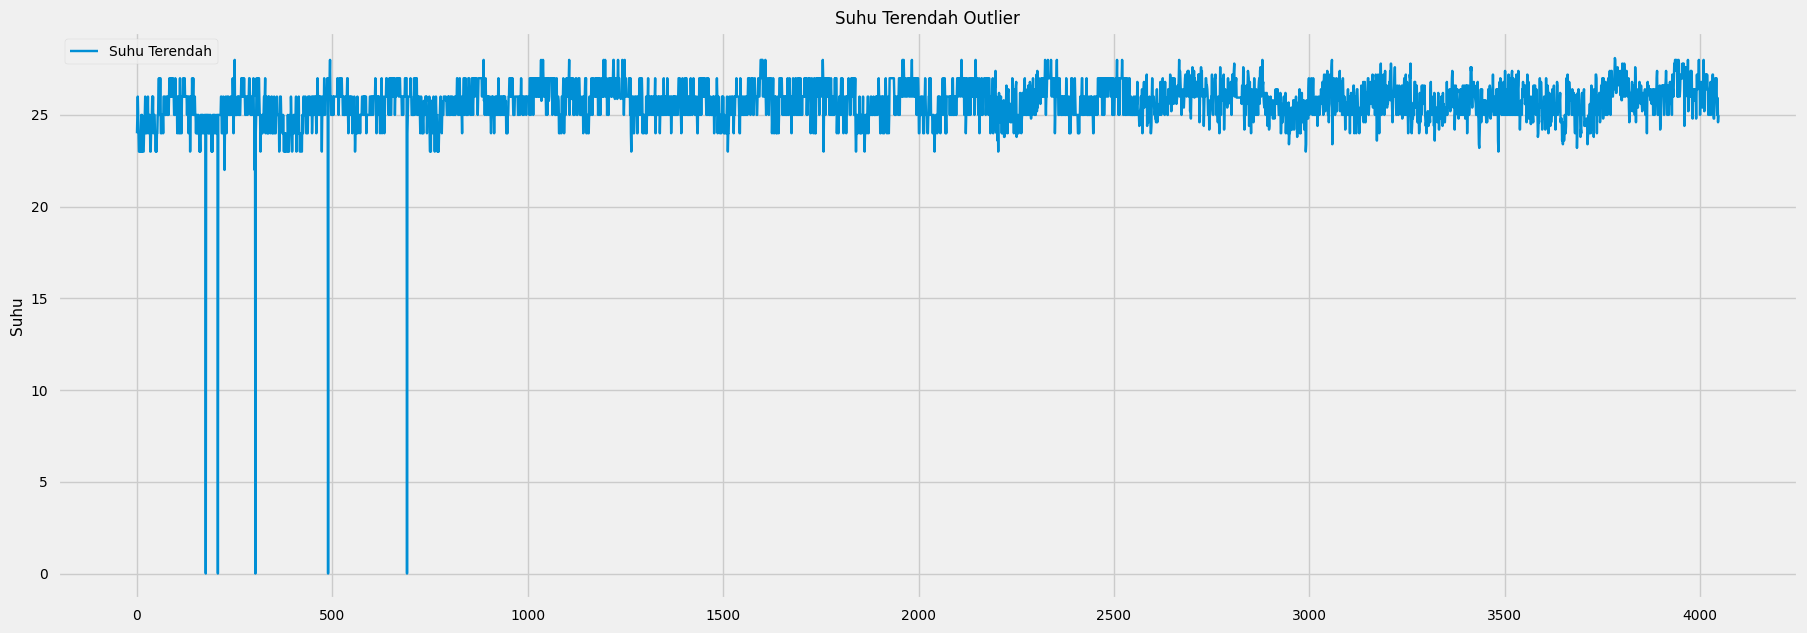

In [10]:
plt.figure(figsize=(20, 7))
plt.plot(climate_data['Tn'], label='Suhu Terendah')
plt.title('Suhu Terendah Outlier')
plt.ylabel('Suhu')
plt.legend()
plt.show()

In [11]:
# mencari posisi nilai 0 pada variabel Tn
data_hilang = int(len(climate_data['Tn'].nsmallest()))

# Menampilkan n data dengan nilai terkecil pada variabel Tn
climate_data.nsmallest(data_hilang, 'Tn')

Tanggal   Tn    Tx  Tavg  RH_avg   RR   ss  ff_x  ff_avg  Tahun
176 2013-06-26  0.0  32.8  28.0    80.0  0.0  3.2   3.0     2.0   2013
207 2013-07-27  0.0  32.8  28.0    80.0  0.0  3.2   3.0     2.0   2013
303 2013-10-31  0.0  33.8  28.5    78.0  0.0  1.0   5.0     2.0   2013
489 2014-05-05  0.0  35.2  30.1    75.0  0.0  4.9   5.0     2.0   2014
691 2014-11-23  0.0  34.0  30.4    71.0  0.0  5.5   4.0     2.0   2014

In [12]:
# Mengganti nilai 0 pada kolom 'Tn' dengan nilai rata-rata tahunan yang sesuai
climate_data['Tn'] = climate_data.apply(lambda row: mean_pertahun.loc[row.name, 'Tn'] if row['Tn'] == 0 else row['Tn'], axis=1)
climate_data.min()

Tanggal    2013-01-01 00:00:00
Tn                        22.0
Tx                        23.8
Tavg                      24.1
RH_avg                    52.0
RR                         0.0
ss                         0.0
ff_x                       0.0
ff_avg                     0.0
Tahun                     2013
dtype: object

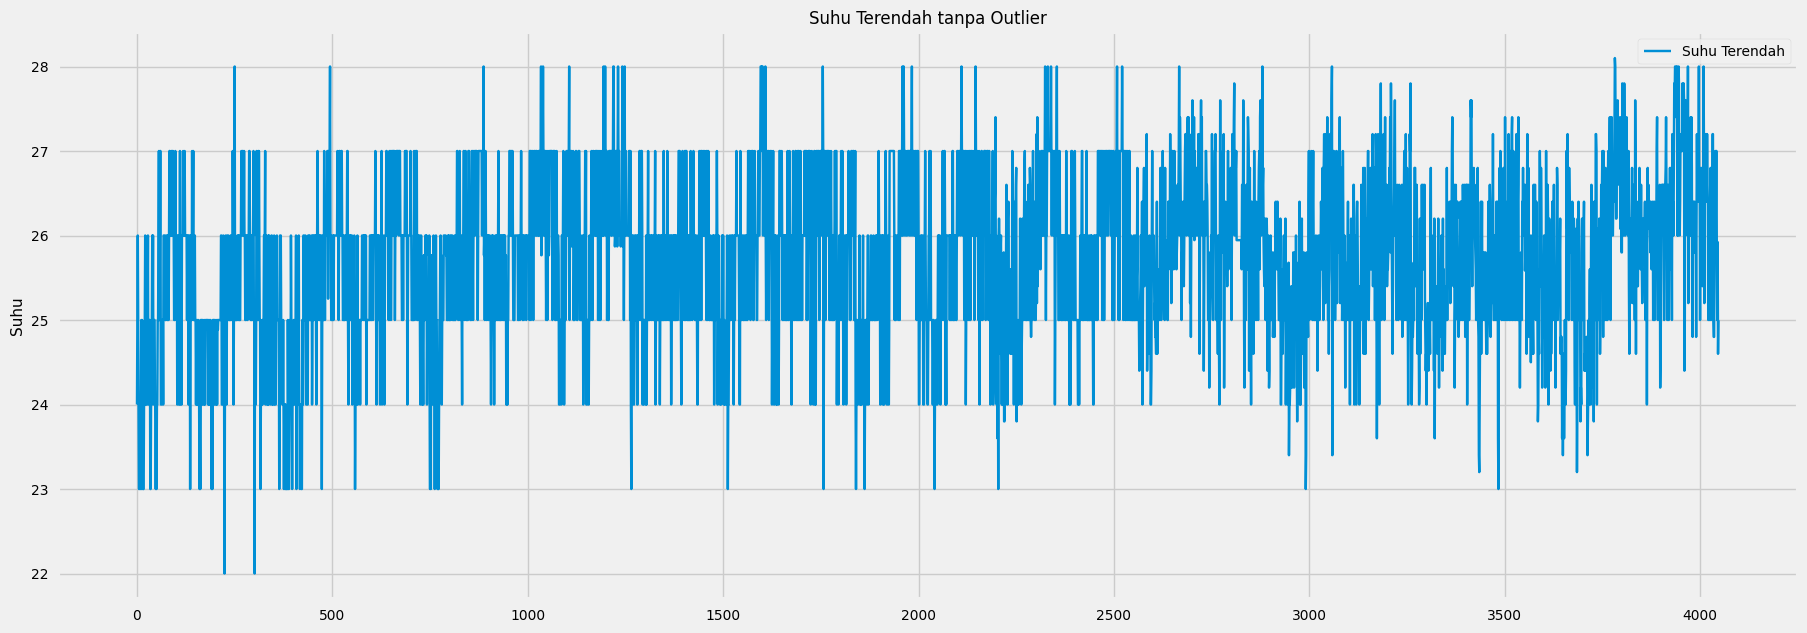

In [13]:
plt.figure(figsize=(20, 7))
plt.plot(climate_data['Tn'], label='Suhu Terendah')
plt.title('Suhu Terendah tanpa Outlier')
plt.ylabel('Suhu')
plt.legend()

In [14]:
# Mengubah kolom tanggal menjadi index karena ini merupakan data deret waktu
climate_data.set_index('Tanggal', inplace=True)
climate_data.head(5)

Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ff_avg  Tahun
Tanggal                                                             
2013-01-01  24.0  31.8  26.2    91.0   1.7  3.5   6.0     3.0   2013
2013-01-02  25.0  31.4  27.9    79.0   0.0  1.2   4.0     3.0   2013
2013-01-03  26.0  32.6  28.6    79.0   1.3  3.5   5.0     4.0   2013
2013-01-04  25.0  30.2  26.3    86.0  34.4  0.4   9.0     5.0   2013
2013-01-05  24.0  30.8  26.6    82.0   6.4  4.8   7.0     4.0   2013

In [15]:
# menghapus kolom Tahun karena sudah tidak terpakai
climate_data.drop(columns=['Tahun'], inplace=True)
climate_data.head(5)

Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ff_avg
Tanggal                                                      
2013-01-01  24.0  31.8  26.2    91.0   1.7  3.5   6.0     3.0
2013-01-02  25.0  31.4  27.9    79.0   0.0  1.2   4.0     3.0
2013-01-03  26.0  32.6  28.6    79.0   1.3  3.5   5.0     4.0
2013-01-04  25.0  30.2  26.3    86.0  34.4  0.4   9.0     5.0
2013-01-05  24.0  30.8  26.6    82.0   6.4  4.8   7.0     4.0

In [16]:
# mengecek info dataset
climate_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4049 entries, 2013-01-01 to 2024-02-01
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tn      4049 non-null   float64
 1   Tx      4049 non-null   float64
 2   Tavg    4049 non-null   float64
 3   RH_avg  4049 non-null   float64
 4   RR      4049 non-null   float64
 5   ss      4049 non-null   float64
 6   ff_x    4049 non-null   float64
 7   ff_avg  4049 non-null   float64
dtypes: float64(8)
memory usage: 284.7 KB


In [17]:
# mengecek missing values untuk memastikan tidak ada lagi data yang missing atau hilang
climate_data.isnull().sum()

Tn        0
Tx        0
Tavg      0
RH_avg    0
RR        0
ss        0
ff_x      0
ff_avg    0
dtype: int64

## **Visualisasi**

### Visualisasi Temperatur

In [18]:
# Mengatur parameter matplotlib untuk plotting
plt.rcParams['font.size'] = 18
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (20, 7)
# plt.rcParams['axes.prop_cycle'] = cycler(color=['#1f77b4'])

Text(0, 0.5, 'Jam')

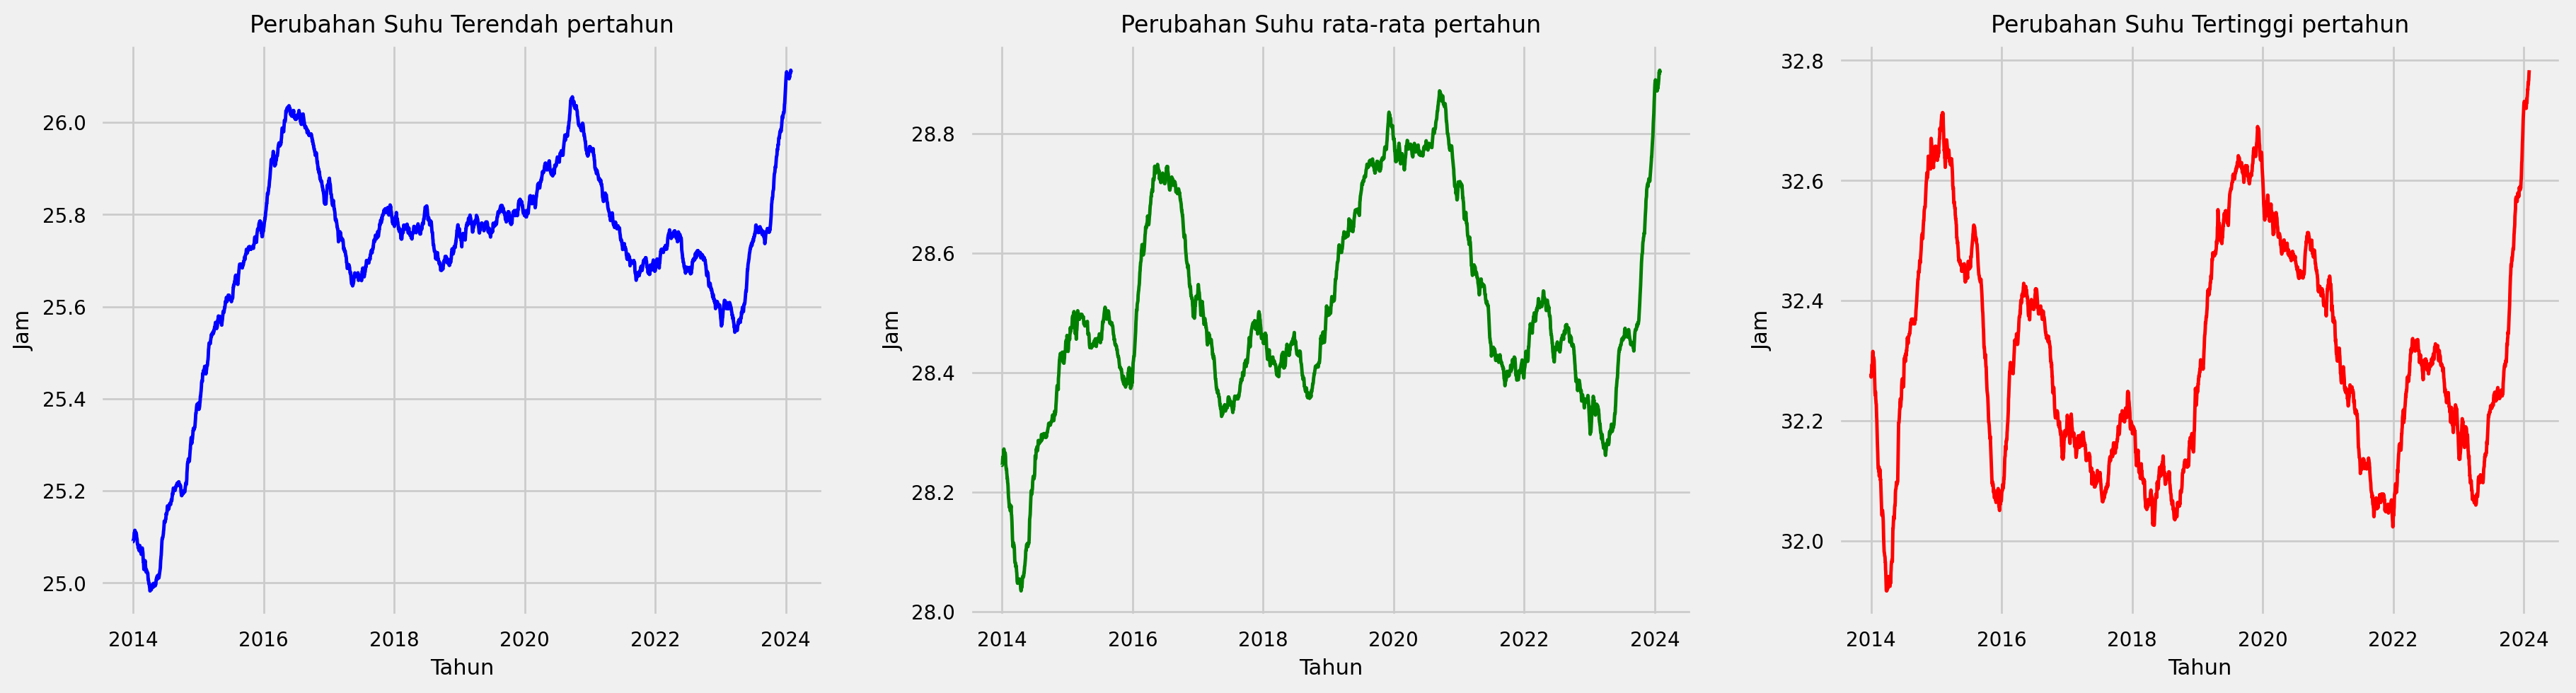

In [19]:
# List kolom yang mau divisualisasi
rolling_avg_Tn = climate_data['Tn'].rolling(window=365).mean()
rolling_avg_Tavg = climate_data['Tavg'].rolling(window=365).mean()
rolling_avg_Tx = climate_data['Tx'].rolling(window=365).mean()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

axs[0].plot(rolling_avg_Tn, label='Tren Tn (365) hari', color='blue')
axs[0].set_title('Perubahan Suhu Terendah pertahun')
axs[0].set_xlabel('Tahun')
axs[0].set_ylabel('Jam')

axs[1].plot(rolling_avg_Tavg, label='Tren Tavg (365) hari', color='green')
axs[1].set_title('Perubahan Suhu rata-rata pertahun')
axs[1].set_xlabel('Tahun')
axs[1].set_ylabel('Jam')

axs[2].plot(rolling_avg_Tx, label='Tren Tx (365) hari', color='red')
axs[2].set_title('Perubahan Suhu Tertinggi pertahun')
axs[2].set_xlabel('Tahun')
axs[2].set_ylabel('Jam')

### Visualisasi Kelembapan (RH_avg)

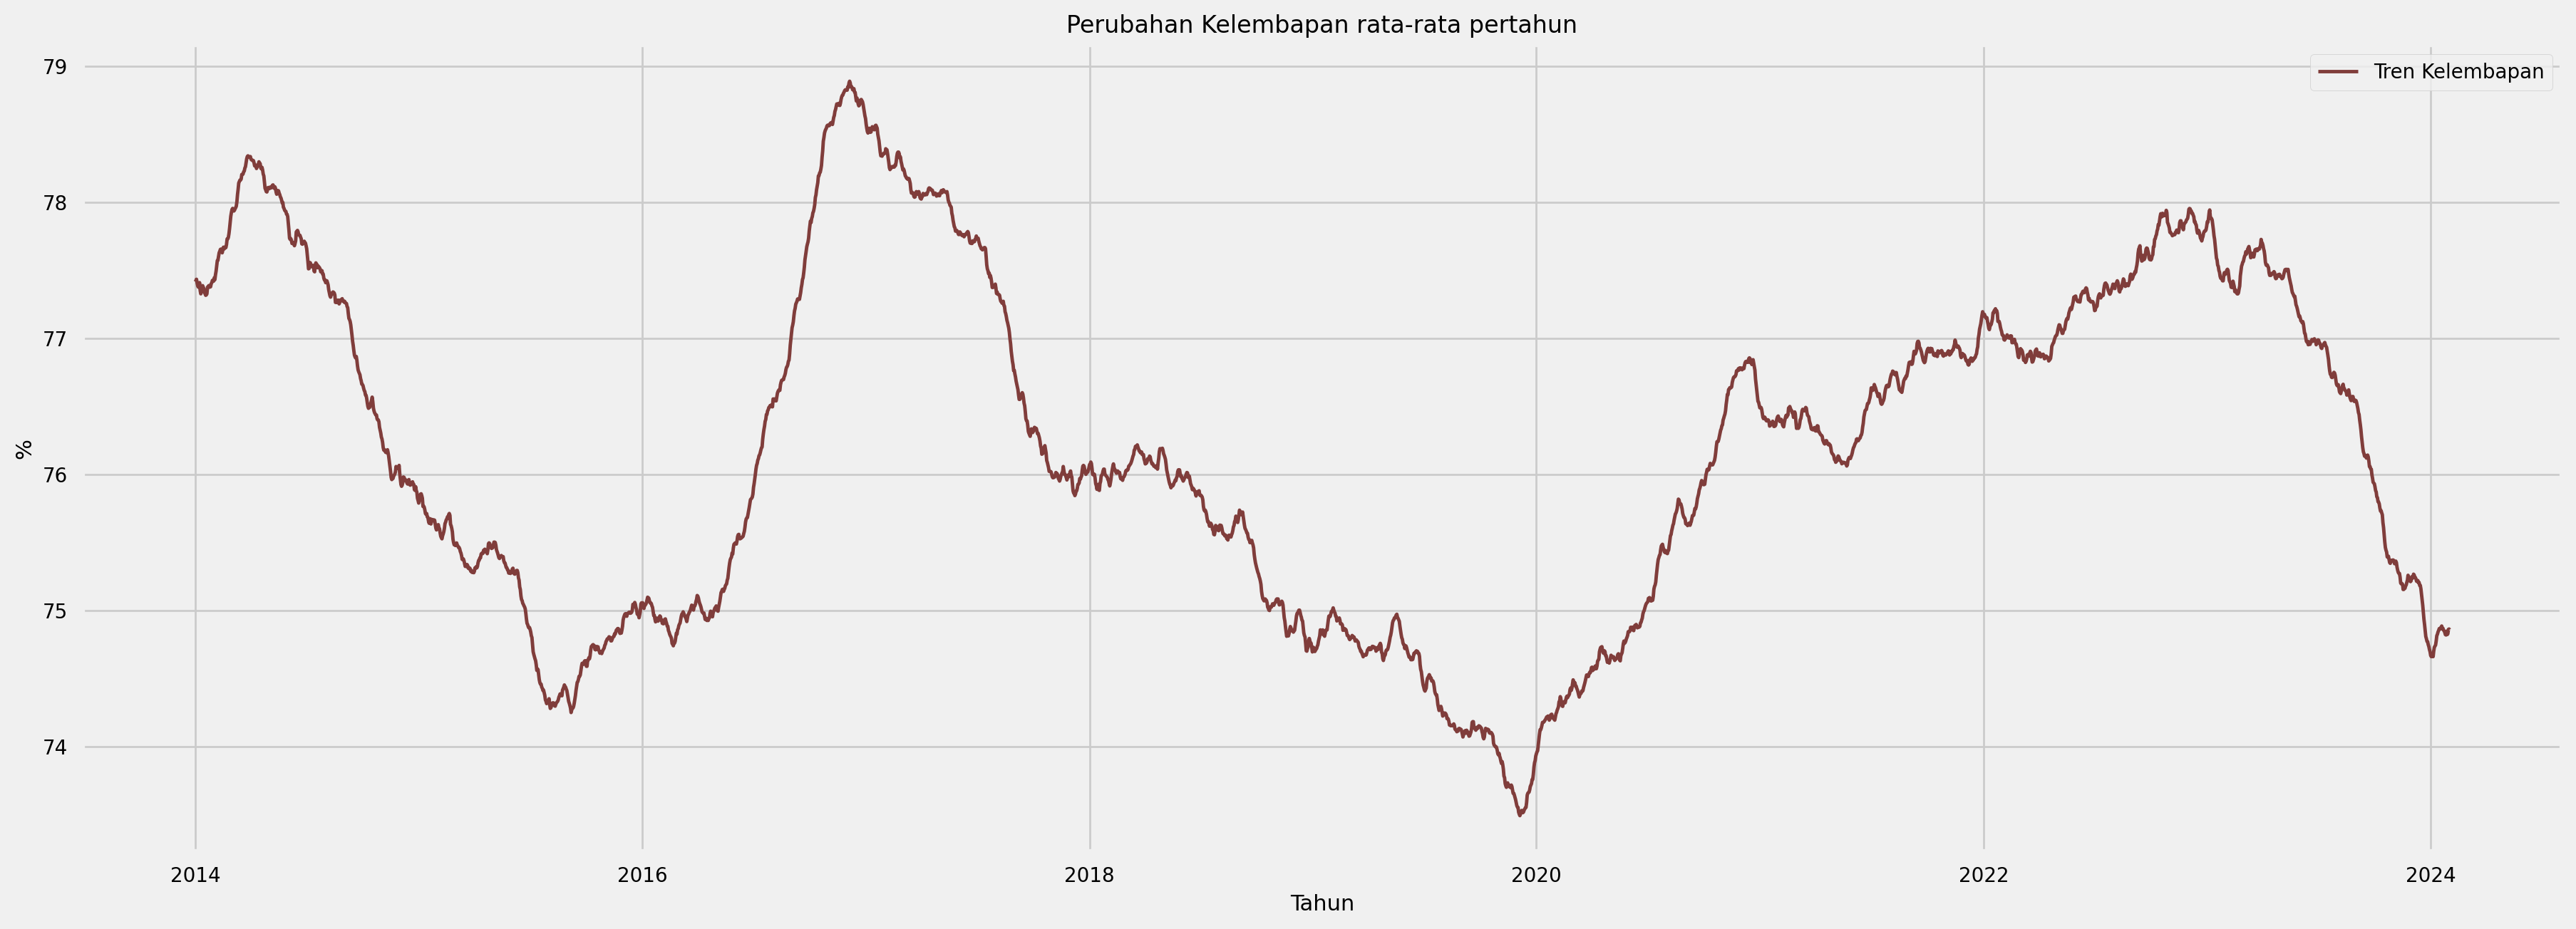

In [20]:
rolling_avg_RH_avg = climate_data['RH_avg'].rolling(window=365).mean()

plt.figure(figsize= (20, 7))
plt.title('Perubahan Kelembapan rata-rata pertahun')
plt.plot(rolling_avg_RH_avg, label='Tren Kelembapan', color='#803D3B')
plt.xlabel('Tahun')
plt.ylabel('%')
plt.legend()
plt.show()

### Visualisasi Curah Hujan (RR)

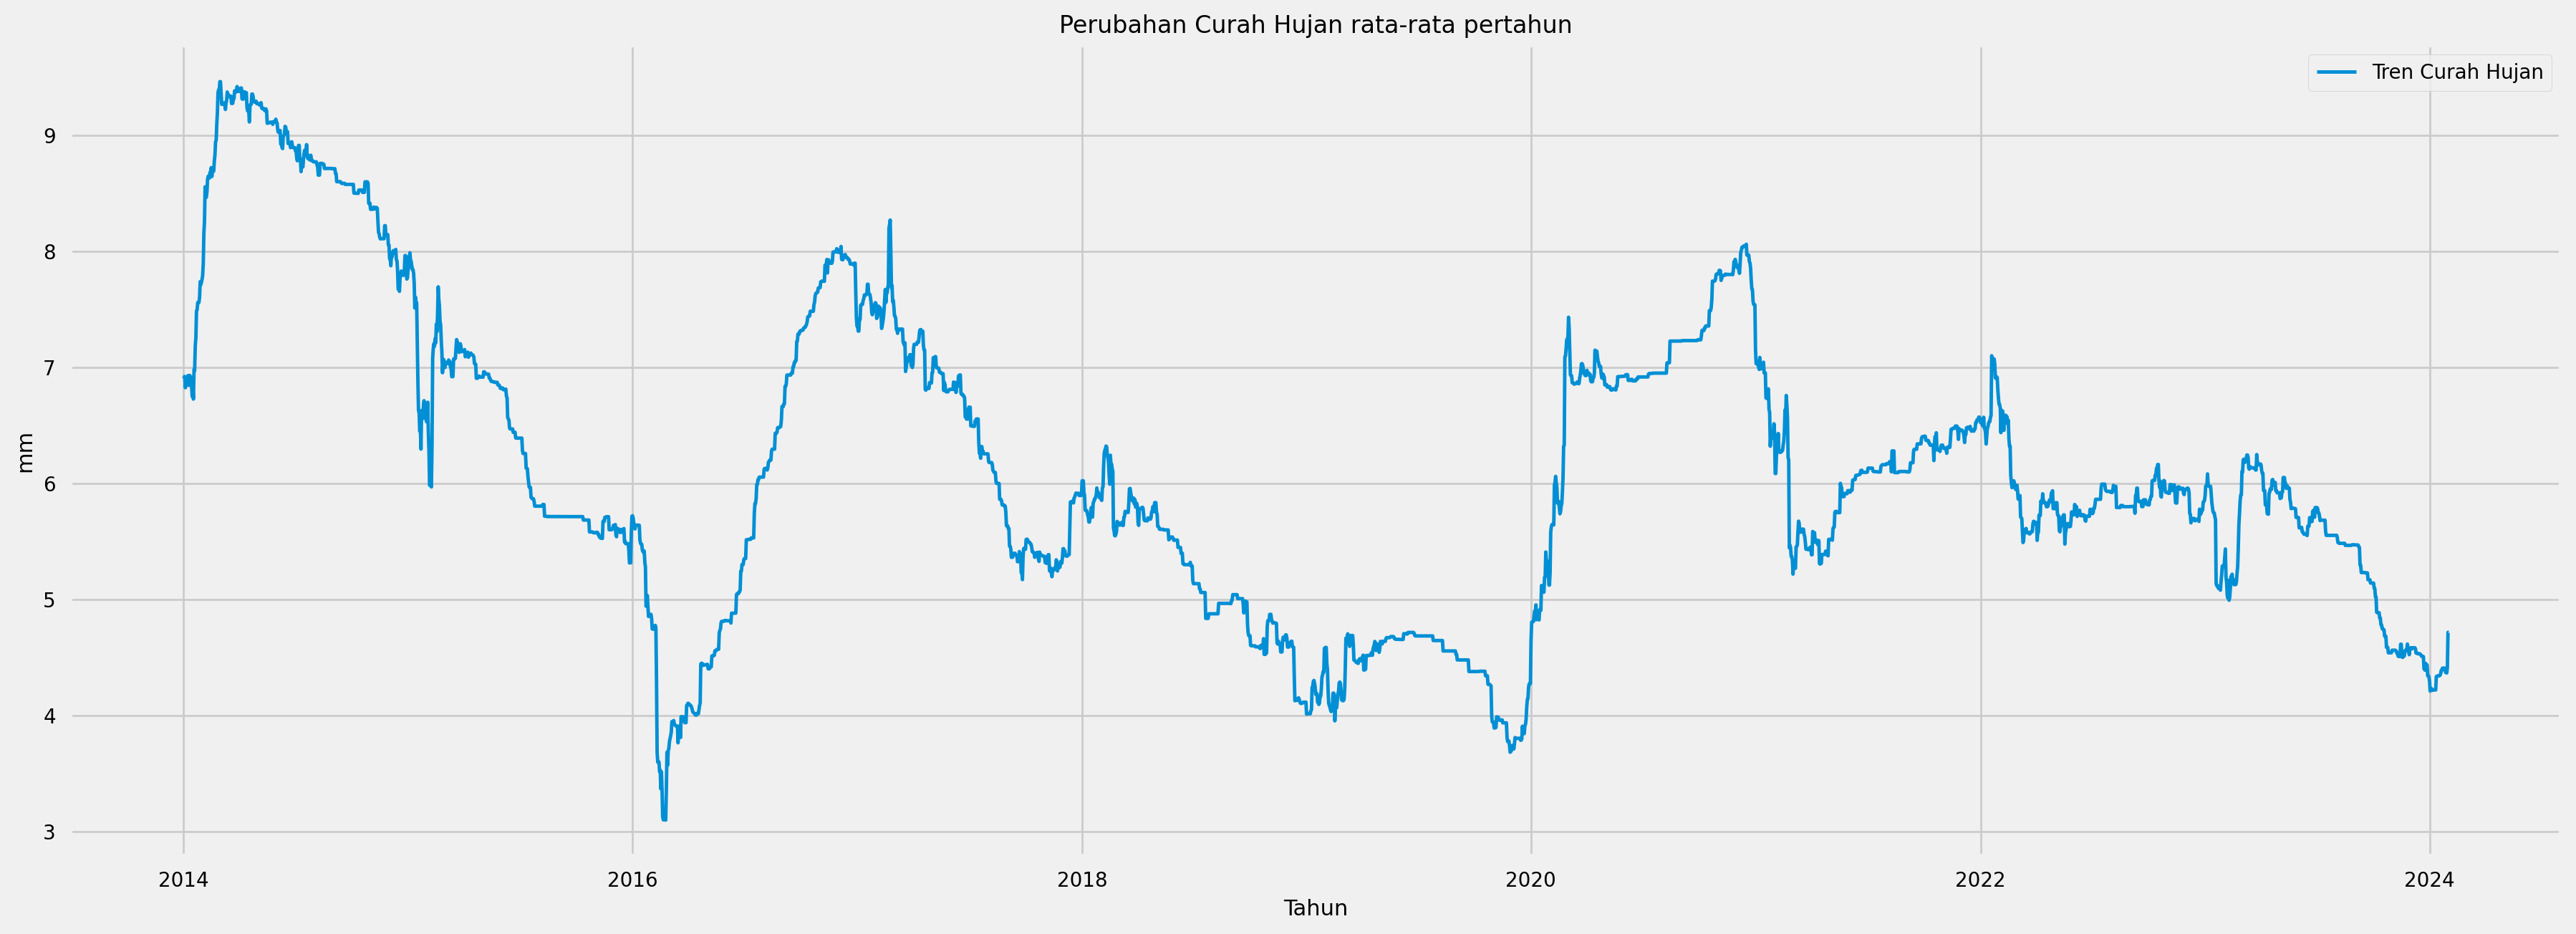

In [21]:
rolling_avg_RR = climate_data['RR'].rolling(window=365).mean()

plt.figure(figsize= (20, 7))
plt.title('Perubahan Curah Hujan rata-rata pertahun')
plt.plot(rolling_avg_RR, label='Tren Curah Hujan')
plt.xlabel('Tahun')
plt.ylabel('mm')
plt.legend()
plt.show()

### Visualisasi Lamanya Penyinaran Matahari

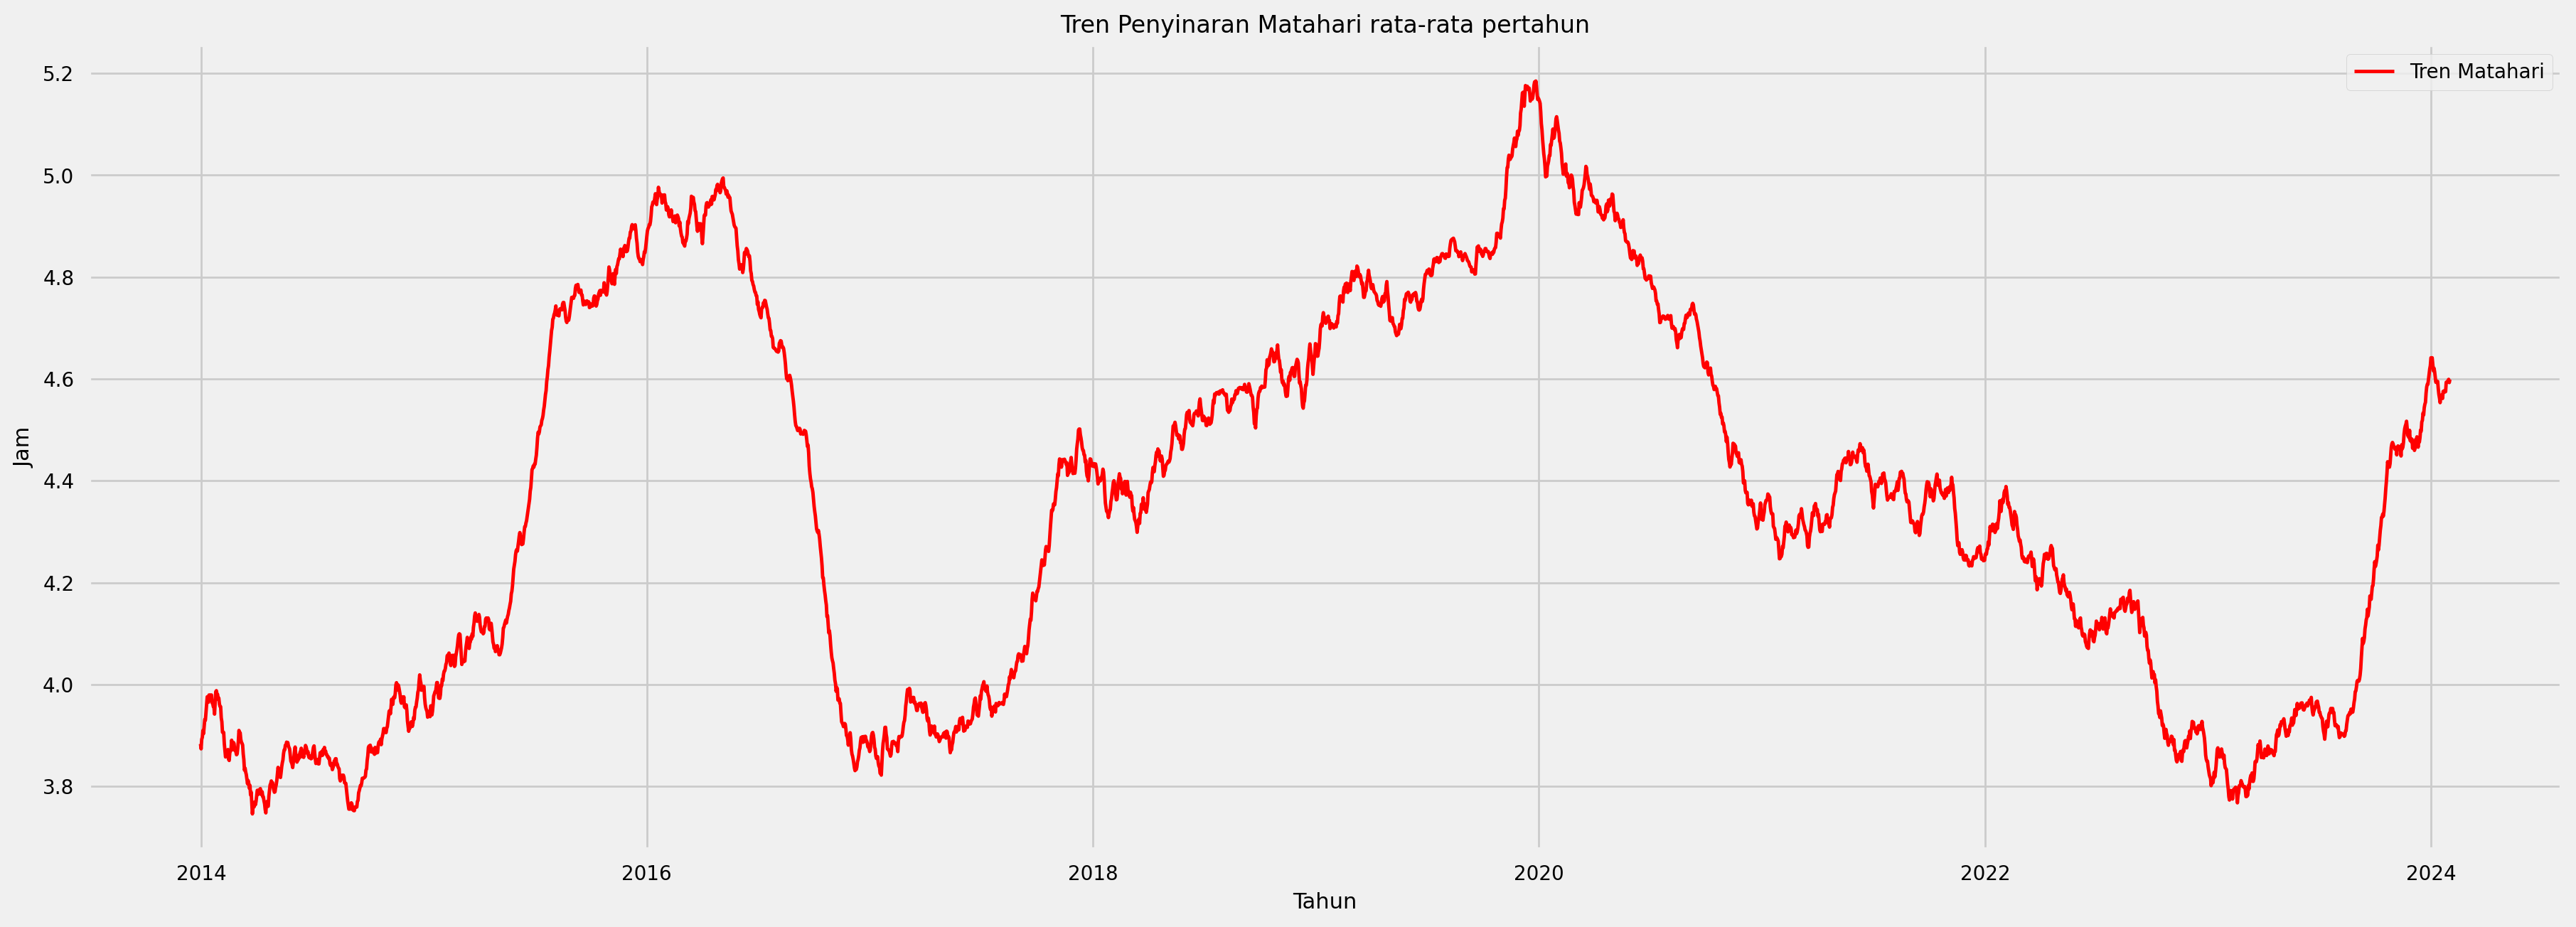

In [22]:
rolling_avg_ss = climate_data['ss'].rolling(window=365).mean()

plt.figure(figsize= (20, 7))
plt.title('Tren Penyinaran Matahari rata-rata pertahun')
plt.plot(rolling_avg_ss, label='Tren Matahari', color='red')
plt.xlabel('Tahun')
plt.ylabel('Jam')
plt.legend()
plt.show()

### Visualisasi Kecepatan Angin Maksimum

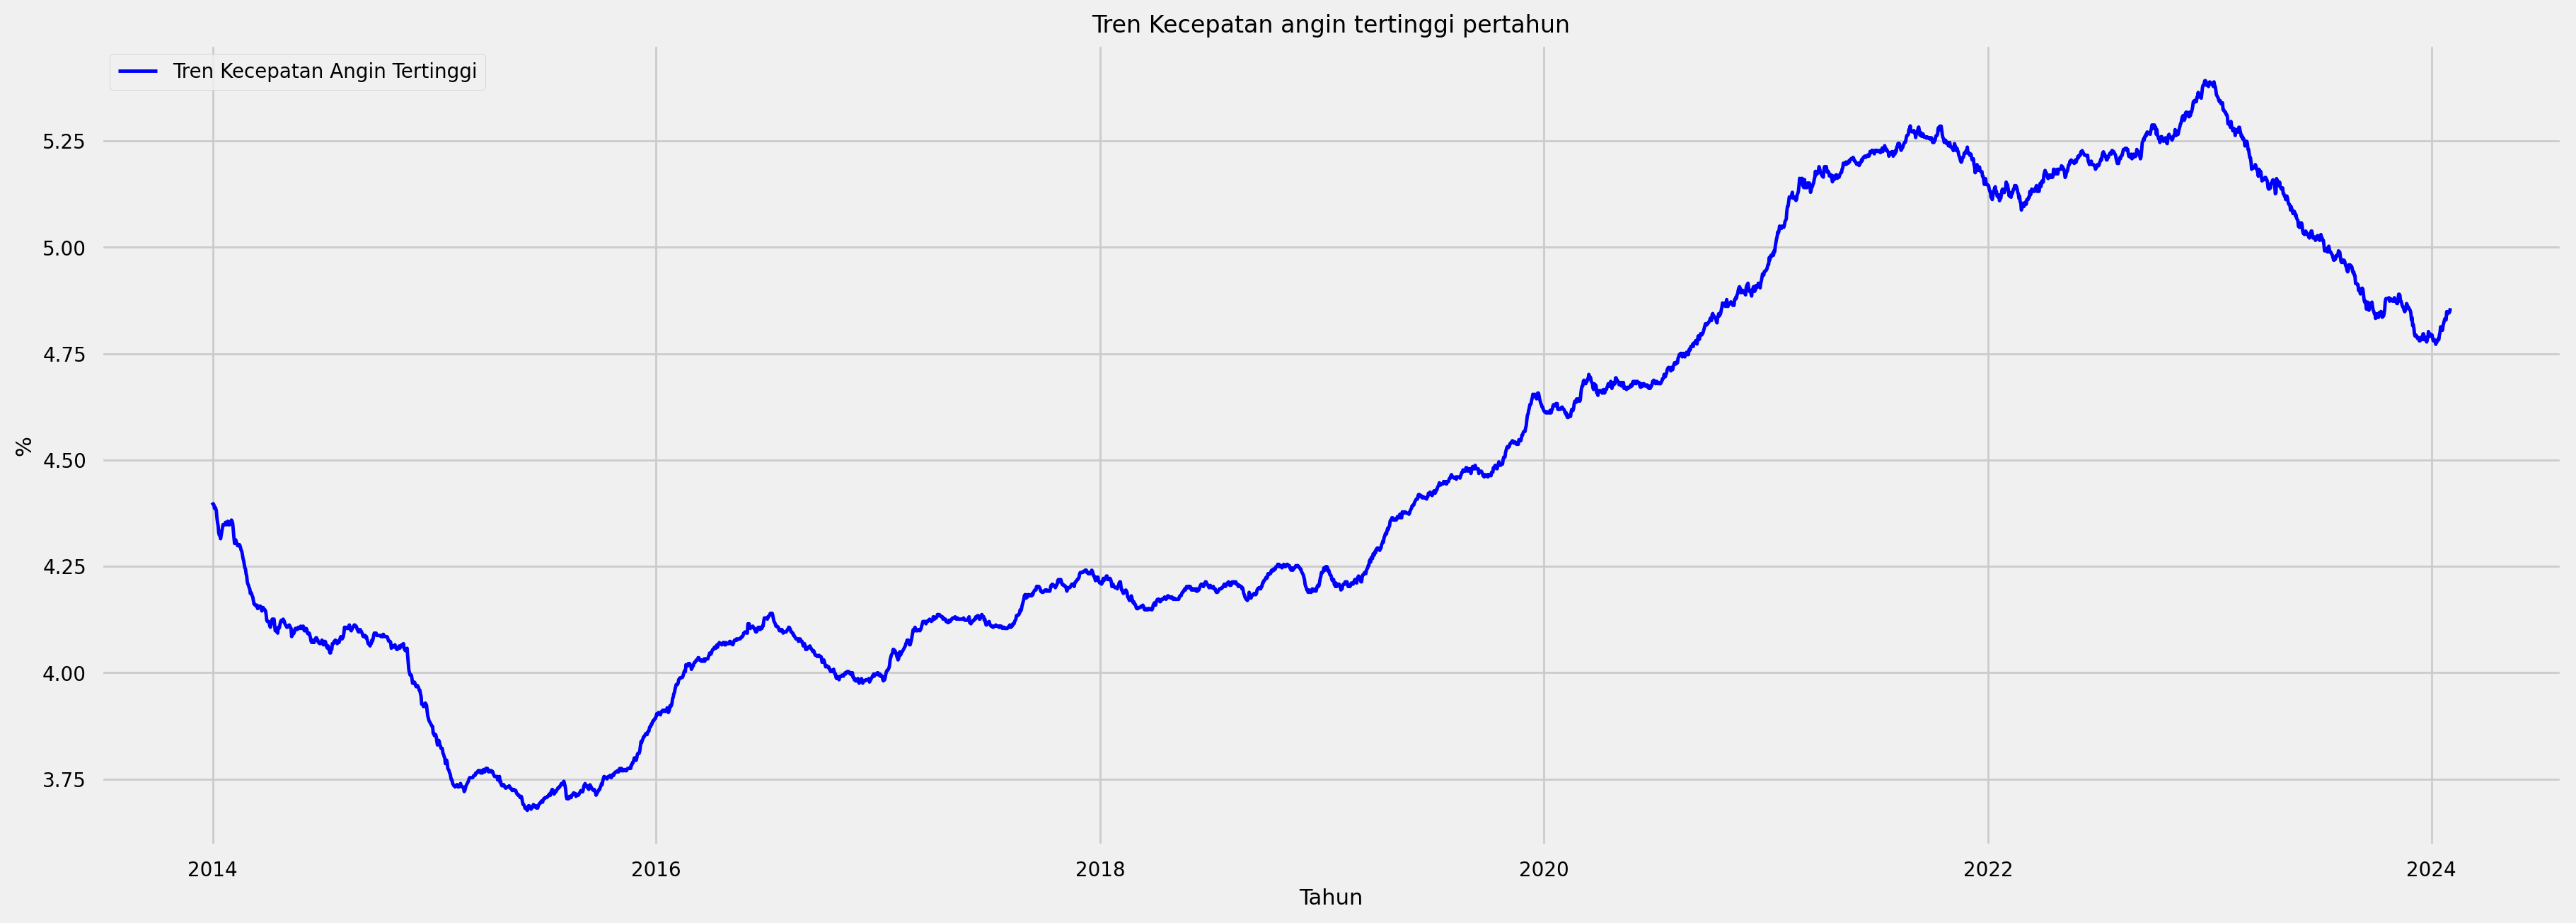

In [23]:
rolling_avg_ffx = climate_data['ff_x'].rolling(window=365).mean()

plt.figure(figsize= (20, 7))
plt.title('Tren Kecepatan angin tertinggi pertahun')
plt.plot(rolling_avg_ffx, label='Tren Kecepatan Angin Tertinggi', color='blue')
plt.xlabel('Tahun')
plt.ylabel('%')
plt.legend()
plt.show()

### Visualisasi Kecepatan Angin rata-rata

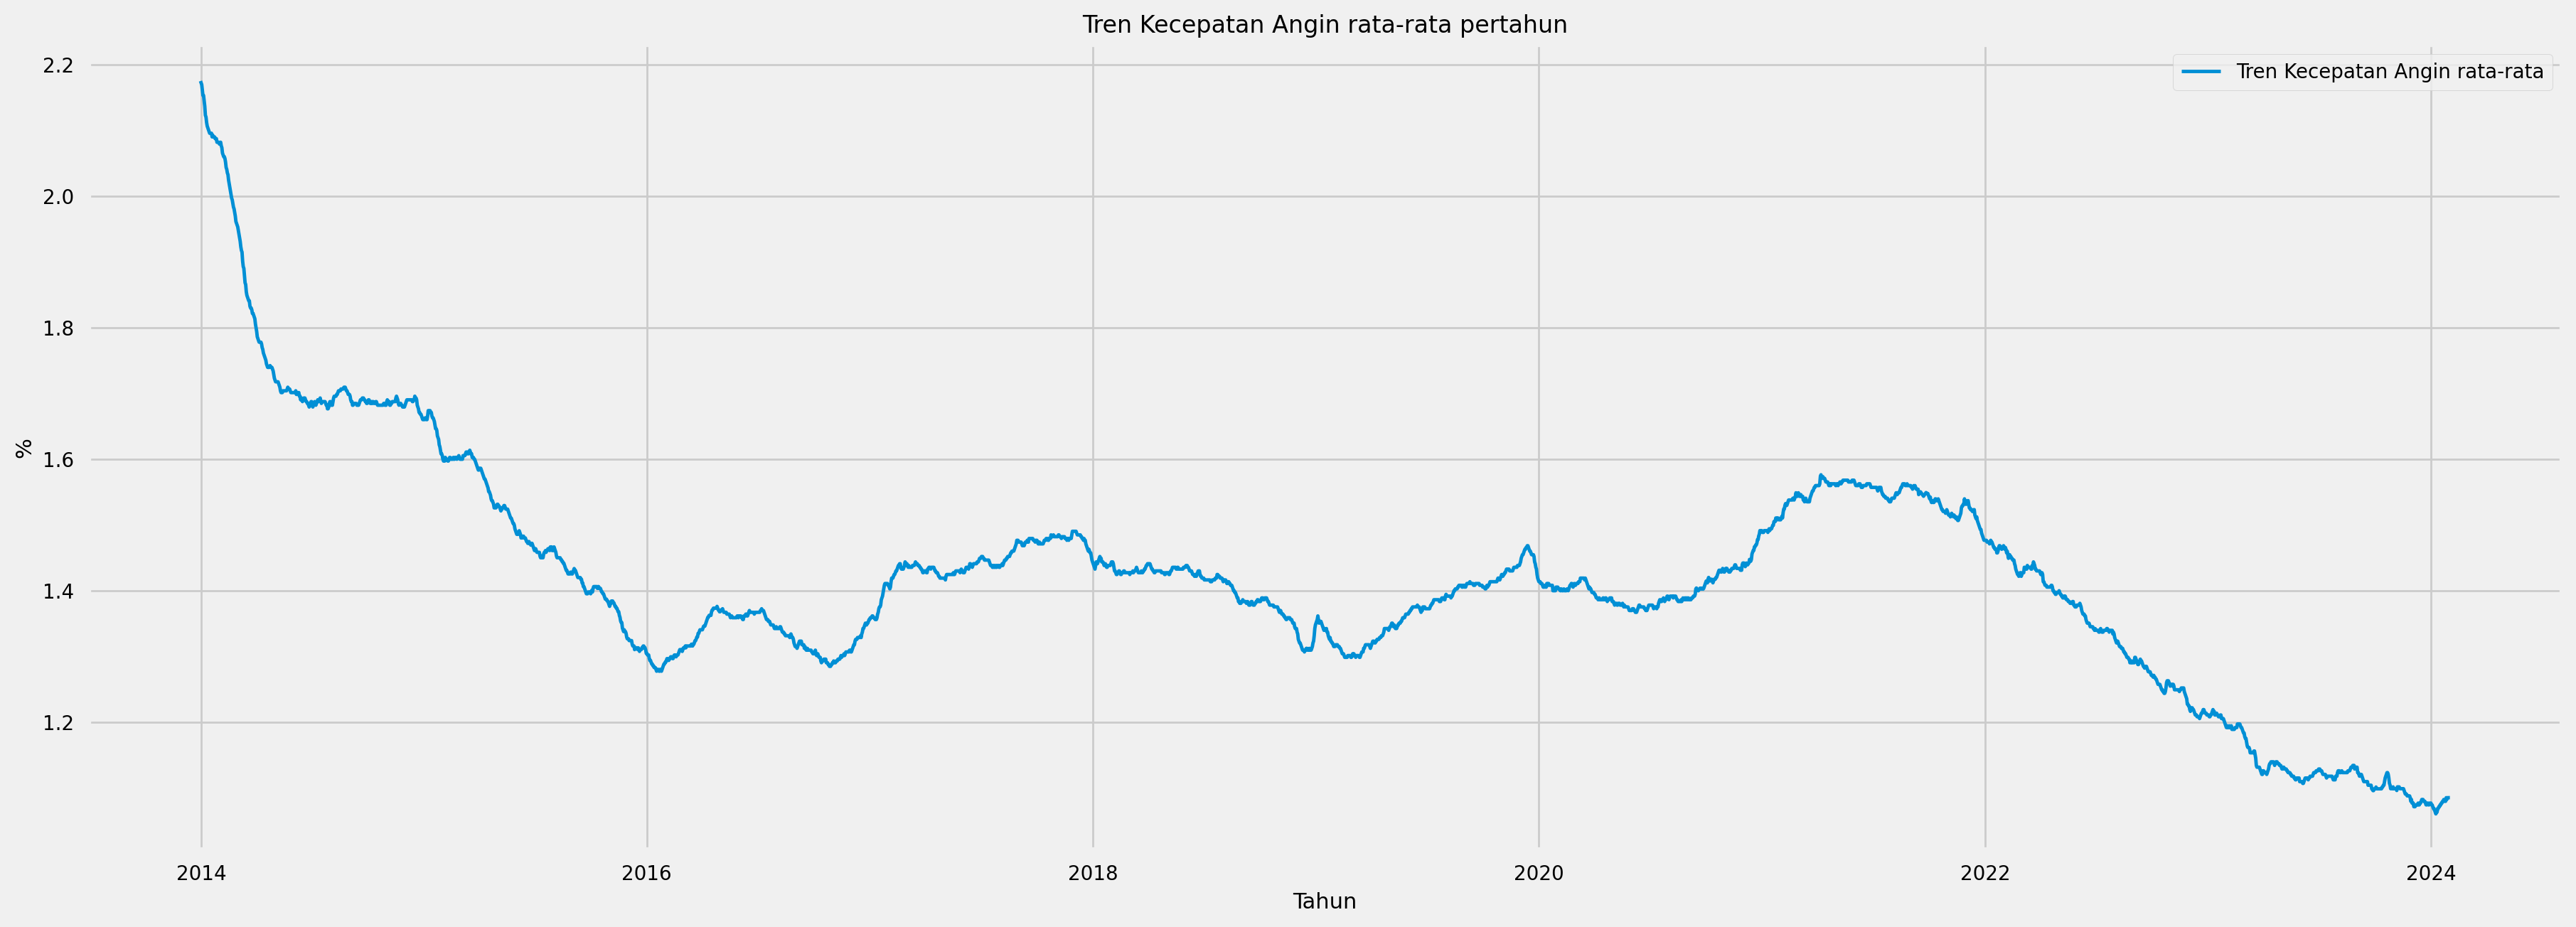

In [24]:
rolling_avg_ffavg = climate_data['ff_avg'].rolling(window=365).mean()

plt.figure(figsize= (20, 7))
plt.title('Tren Kecepatan Angin rata-rata pertahun')
plt.plot(rolling_avg_ffavg, label='Tren Kecepatan Angin rata-rata')
plt.xlabel('Tahun')
plt.ylabel('%')
plt.legend()
plt.show()

## RFE Feature Selection

In [25]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


x = climate_data.drop(columns=['Tx'], axis=1)
y = climate_data['Tx']

In [26]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=5)
rfe.fit(x, y)

RFE(estimator=LinearRegression(), n_features_to_select=5)

In [27]:
# Menampilkan variabel terpilih dalam seleksi

for i, col in zip(range(x.shape[1]), x.columns):
    print(f'{col} terpilih: {rfe.support_[i]} peringkat: {rfe.ranking_[i]}')

Tn terpilih: True peringkat: 1
Tavg terpilih: True peringkat: 1
RH_avg terpilih: True peringkat: 1
RR terpilih: False peringkat: 3
ss terpilih: True peringkat: 1
ff_x terpilih: False peringkat: 2
ff_avg terpilih: True peringkat: 1


# **Perancangan Deep Learning LSTM**

## Memilih Kolom prediksi

In [28]:
# Membuat daftar kolom yang memiliki ranking 1
y = pd.DataFrame(y)
kolom_terpilih = list(y.columns) + list(x.columns[rfe.ranking_ == 1])
print(kolom_terpilih)

['Tx', 'Tn', 'Tavg', 'RH_avg', 'ss', 'ff_avg']


In [29]:
climate_data.head(5) # untuk menampilkan 5 data pertama dari climate_dataset

Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ff_avg
Tanggal                                                      
2013-01-01  24.0  31.8  26.2    91.0   1.7  3.5   6.0     3.0
2013-01-02  25.0  31.4  27.9    79.0   0.0  1.2   4.0     3.0
2013-01-03  26.0  32.6  28.6    79.0   1.3  3.5   5.0     4.0
2013-01-04  25.0  30.2  26.3    86.0  34.4  0.4   9.0     5.0
2013-01-05  24.0  30.8  26.6    82.0   6.4  4.8   7.0     4.0

In [30]:
dataset = climate_data.astype(float) # membuat variabel baru untuk menyimpan dataset yang akan dilatih dan merubah nya data nya ke type float untuk kebutuhan proses kalkulasi agar lebih akurat
dataset.head(3) # menampilkan 3 data pertama dari dataset

Tn    Tx  Tavg  RH_avg   RR   ss  ff_x  ff_avg
Tanggal                                                     
2013-01-01  24.0  31.8  26.2    91.0  1.7  3.5   6.0     3.0
2013-01-02  25.0  31.4  27.9    79.0  0.0  1.2   4.0     3.0
2013-01-03  26.0  32.6  28.6    79.0  1.3  3.5   5.0     4.0

In [31]:
dataset = dataset[kolom_terpilih] # Pemilihan kolom disesuaikan agar sama dengan kolom-kolom yang sudah terpilih dari metode seleksi RFE
dataset.head(3)

Tx    Tn  Tavg  RH_avg   ss  ff_avg
Tanggal                                          
2013-01-01  31.8  24.0  26.2    91.0  3.5     3.0
2013-01-02  31.4  25.0  27.9    79.0  1.2     3.0
2013-01-03  32.6  26.0  28.6    79.0  3.5     4.0

In [32]:
dataset.info() # menampilkan info dari dataset

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4049 entries, 2013-01-01 to 2024-02-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tx      4049 non-null   float64
 1   Tn      4049 non-null   float64
 2   Tavg    4049 non-null   float64
 3   RH_avg  4049 non-null   float64
 4   ss      4049 non-null   float64
 5   ff_avg  4049 non-null   float64
dtypes: float64(6)
memory usage: 221.4 KB


In [33]:
dataset.isnull().sum() # mengecek kembali missing values

Tx        0
Tn        0
Tavg      0
RH_avg    0
ss        0
ff_avg    0
dtype: int64

## Membagi dataset

In [34]:
train_size = int(len(dataset) * 0.9)
print(f"Ukuran Data latih: {train_size}")

Ukuran Data latih: 3644


In [35]:
data_untuk_dilatih = dataset[:train_size]
data_untuk_ditest = dataset[train_size:]

print(f'Data latih: {data_untuk_dilatih.shape}')
print(f'Data uji: {data_untuk_ditest.shape}')

Data latih: (3644, 6)
Data uji: (405, 6)


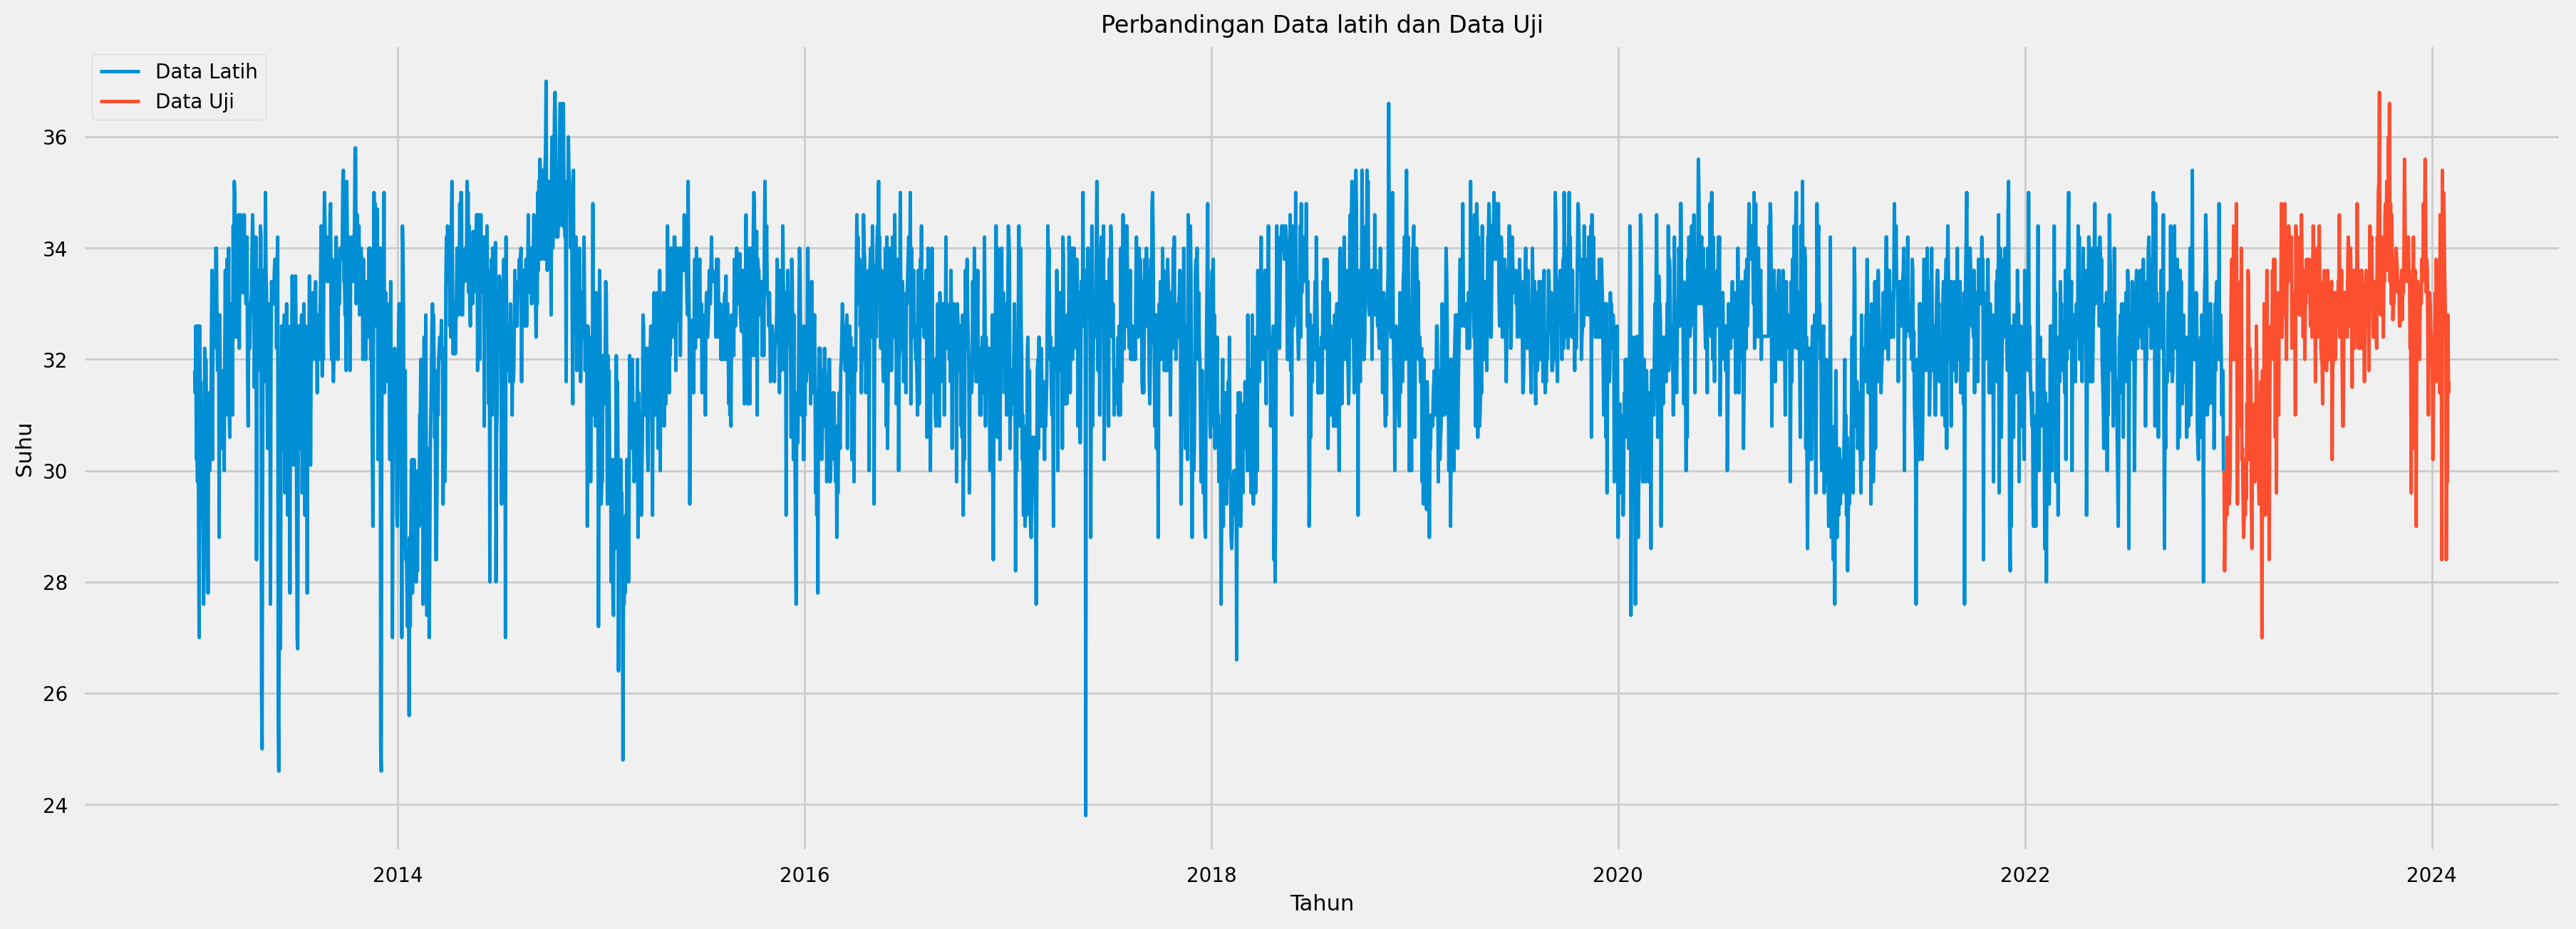

In [36]:
# Visualisasi Hasil pembagian dataset.
plt.figure(figsize= (20, 7))
plt.title('Perbandingan Data latih dan Data Uji')
plt.plot(climate_data['Tx'][:train_size], label='Data Latih')
plt.plot(climate_data['Tx'][train_size:], label='Data Uji')
plt.xlabel('Tahun')
plt.ylabel('Suhu')
plt.legend()
plt.show()

## Normalisasi Data

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_untuk_dilatih_scaled = scaler.fit_transform(data_untuk_dilatih)
data_untuk_ditest_scaled = scaler.fit_transform(data_untuk_ditest)

## Membuat Set Pelatihan

In [38]:
# membuat set pelatihan
# dengan contoh ini kita akan memprediksi data ke 15 dengan menggunakan data ke 0 - 14 untuk proses pelatihan.
# kemudian mesin akan menggunakan data ke 1 - 15 untuk memprediksi data ke 16, begitu pula seterusnya.

trainX = []
trainY = []

n_future = 1 # variabel yang akan memprediksi 1 hari kedepan untuk proses pelatihan
n_past = 14 # variabel yang akan menggunakan 14 data terakhir untuk memprediksi data berikutnya,

for i in range(n_past, len(data_untuk_dilatih_scaled) - n_future +1):
    trainX.append(data_untuk_dilatih_scaled[i - n_past:i, 0:data_untuk_dilatih.shape[1]])
    trainY.append(data_untuk_dilatih_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (3630, 14, 6).
trainY shape == (3630, 1).


## Membuat Model LSTM

### Load model deep learning

In [39]:
# link_model = ''

# custom_objects = {'mse': MeanSquaredError()}
# model = load_model(link_model, custom_objects)
# model.summary()

### Membuat Model LSTM

In [40]:
model = Sequential() # model menggunakan jenis sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)) # layer pertama menggunakan Algoritma LSTM dengan 64 Unit neuron dan aktivasi 'Rectified linear unit' atau 'relu'
model.add(LSTM(32, activation='relu', return_sequences=False)) # layer kedua tetap menggunakan algoritma LSTM dengan 32 unit neuron dan aktivasi relu.
model.add(Dropout(0.2)) # layer ketiga adalah dropout untuk menghilangkan sekitar 20% unit neuron secara acak guna menghindari over-vitting (model menjadi pusing karena mencoba menghitung ribuan data didalam 1 neuron sekaligus)
model.add(Dense(trainY.shape[1])) # layer keempat sebagai output atau keluaran dari proses rumit neural network LSTM

model.compile(optimizer='adam', loss='mse') # model akan dikompile menggunakan optimasi adam, yaitu optimasi yang cukup populer di dunia deep learning karena proses komputasi lebih ringan dan memiliki learning rate yang rendah
model.summary() # menampilkan ringkasan desain model yang sudah dibuat

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            18176     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


### Membuat model RNN

In [ ]:
# model = Sequential() # model menggunakan jenis sequential()
# model.add(SimpleRNN(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)) # layer pertama menggunakan Algoritma LSTM dengan 64 Unit neuron dan aktivasi 'Rectified linear unit' atau 'relu'
# model.add(SimpleRNN(32, activation='relu', return_sequences=False)) # layer kedua tetap menggunakan algoritma LSTM dengan 32 unit neuron dan aktivasi relu.
# model.add(Dropout(0.2)) # layer ketiga adalah dropout untuk menghilangkan sekitar 20% unit neuron secara acak guna menghindari over-vitting (model menjadi pusing karena mencoba menghitung ribuan data didalam 1 neuron sekaligus)
# model.add(Dense(trainY.shape[1])) # layer keempat sebagai output atau keluaran dari proses rumit neural network LSTM

# model.compile(optimizer='adam', loss='mse') # model akan dikompile menggunakan optimasi adam, yaitu optimasi yang cukup populer di dunia deep learning karena proses komputasi lebih ringan dan memiliki learning rate yang rendah
# model.summary() # menampilkan ringkasan desain model yang sudah dibuat

### Pelatihan model

In [41]:
history = model.fit(trainX, trainY, epochs=75, batch_size=32, validation_split=0.1)

Epoch 1/75
103/103 [==============================] - 4s 14ms/step - loss: 0.0399 - val_loss: 0.0113
Epoch 2/75
103/103 [==============================] - 1s 10ms/step - loss: 0.0183 - val_loss: 0.0113
Epoch 3/75
103/103 [==============================] - 1s 10ms/step - loss: 0.0166 - val_loss: 0.0111
Epoch 4/75
103/103 [==============================] - 1s 10ms/step - loss: 0.0156 - val_loss: 0.0089
Epoch 5/75
103/103 [==============================] - 1s 9ms/step - loss: 0.0151 - val_loss: 0.0093
Epoch 6/75
103/103 [==============================] - 1s 10ms/step - loss: 0.0151 - val_loss: 0.0089
Epoch 7/75
103/103 [==============================] - 1s 9ms/step - loss: 0.0144 - val_loss: 0.0088
Epoch 8/75
103/103 [==============================] - 1s 9ms/step - loss: 0.0143 - val_loss: 0.0093
Epoch 9/75
103/103 [==============================] - 1s 10ms/step - loss: 0.0141 - val_loss: 0.0088
Epoch 10/75
103/103 [==============================] - 1s 10ms/step - loss: 0.0136 - val_loss:

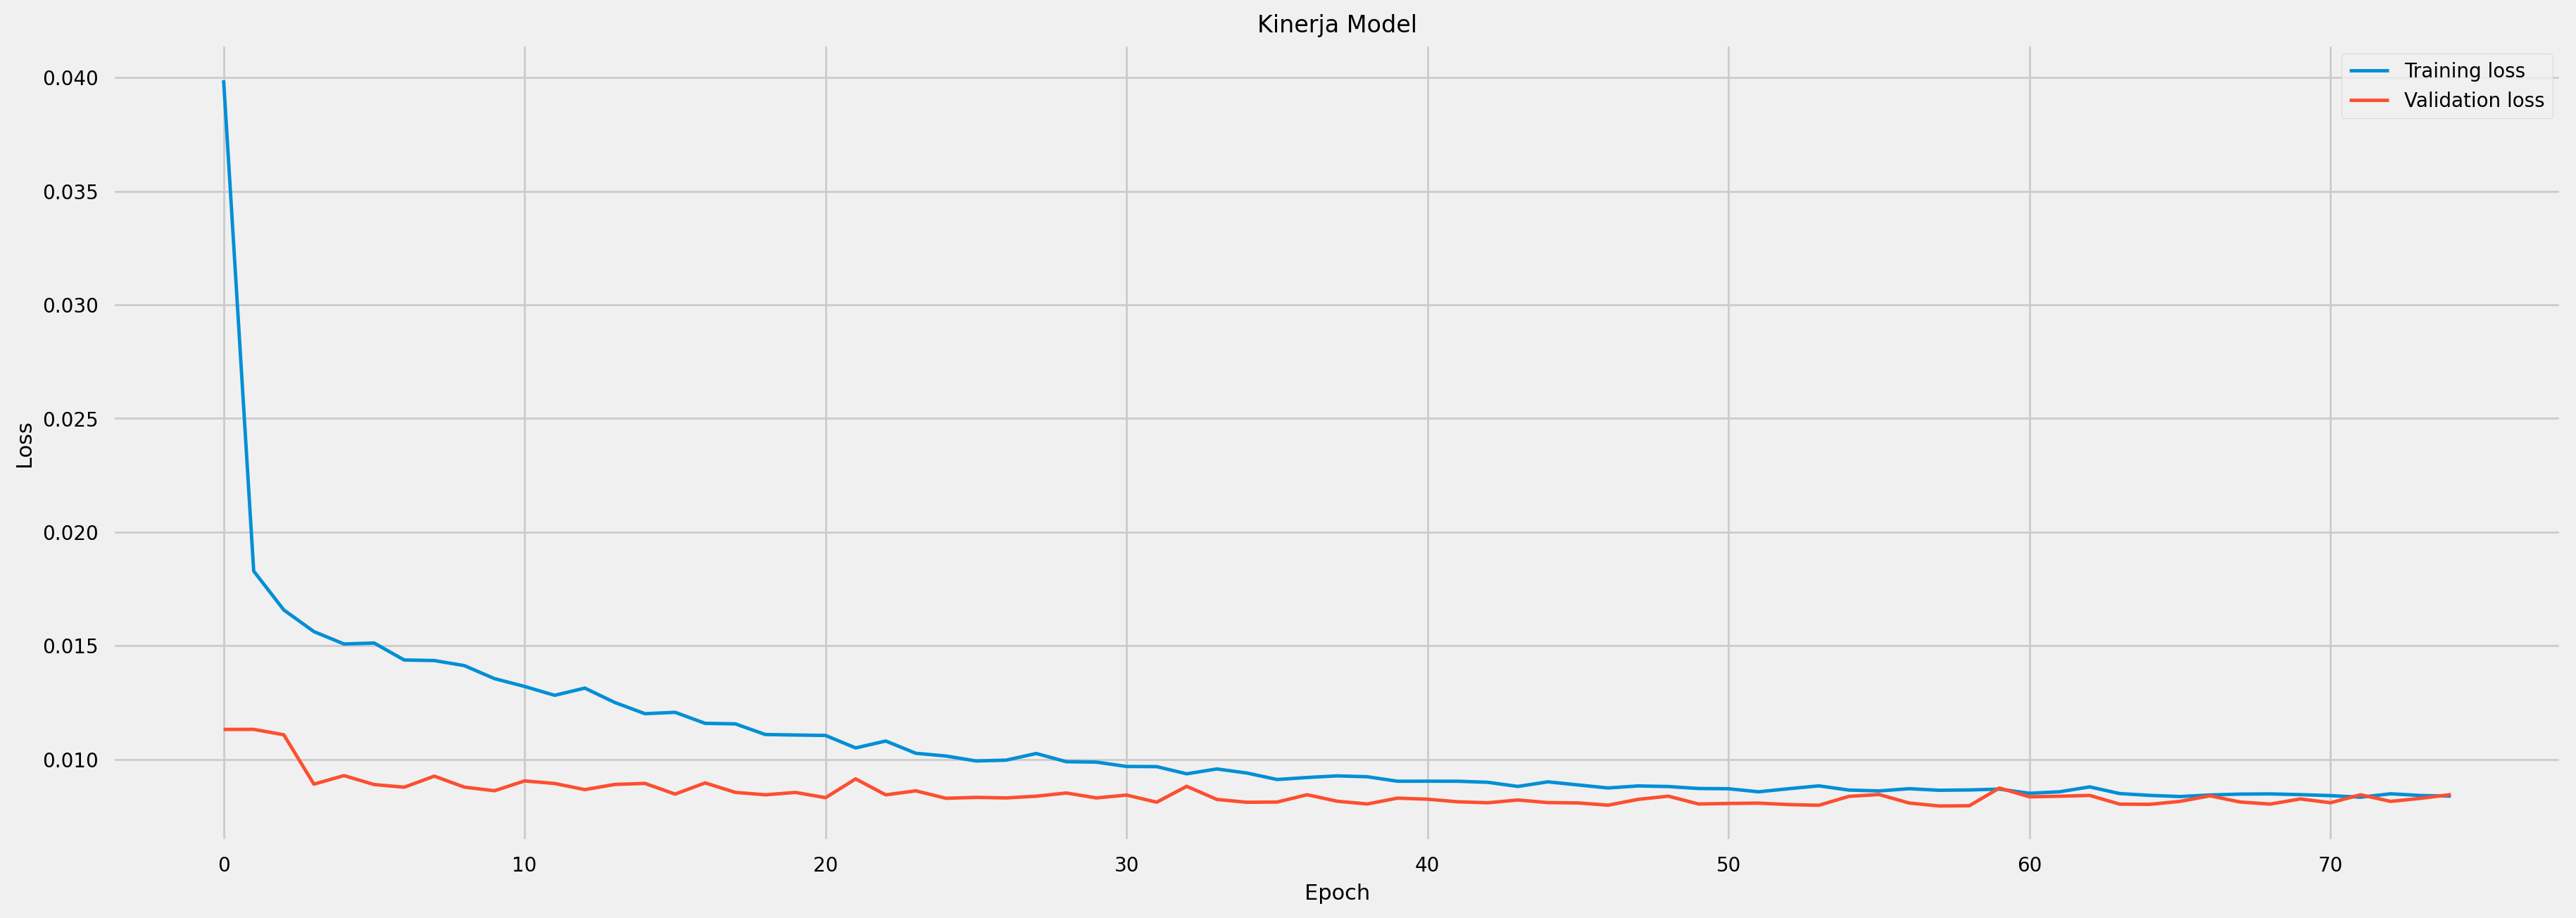

In [42]:
plt.figure(figsize= (20, 7))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Kinerja Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Prediksi**

## Membuat Set Pengujian

In [43]:
# membuat set pengujian
# dengan contoh ini kita akan memprediksi data ke 15 dengan menggunakan data ke 0 - 14 untuk proses pengujian.
# kemudian mesin akan menggunakan data ke 1 - 15 untuk memprediksi data ke 16, begitu pula seterusnya.

testX = []
testY = []

n_future = 1 # variabel yang akan memprediksi 1 hari kedepan untuk proses pengujian
n_past = 14 # variabel yang akan menggunakan 14 data terakhir untuk memprediksi data berikutnya,

for i in range(n_past, len(data_untuk_ditest_scaled) - n_future +1):
    testX.append(data_untuk_ditest_scaled[i - n_past:i, 0:data_untuk_ditest.shape[1]])
    testY.append(data_untuk_ditest_scaled[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (391, 14, 6).
testY shape == (391, 1).


In [44]:
future = 365 # variabel untuk menentukan berapa banyak data yang akan diprediksi ke masa depan
forecast_periode_tanggal = pd.date_range(list(climate_data.index)[-1], periods=future, freq='1d').tolist() # untuk mengambil periode 'tanggalan' dari dataset original yaitu climate_data

In [45]:
forecast = model.predict(testX[-future:]) # melakukan proses prediksi 1 tahun ke masa depan

12/12 [==============================] - 0s 4ms/step


In [46]:
# melakukan denormaliasi yaitu proses merubah nilai data ke bentuk/skala yang asli

forecast_copies = np.repeat(forecast, dataset.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [47]:
# Membuat tabel untuk menyimpan data hasil prediksi agar lebih mudah untuk dilihat dan di plotting

data_hasil = pd.DataFrame(y_pred_future, columns=['Prediksi']) # membuat konversi hasil dari perhitungan ke dalam bentuk tabel
data_hasil['Tanggal'] = forecast_periode_tanggal # Menambahkan tanggalan agar data mudah dibaca
data_hasil.set_index('Tanggal', inplace=True) # menjadikan tanggalan sebagai index karena dataset berupa timeseries
data_hasil

Prediksi
Tanggal              
2024-02-01  31.497820
2024-02-02  30.949684
2024-02-03  31.470650
2024-02-04  31.174635
2024-02-05  32.464069
...               ...
2025-01-26  32.619511
2025-01-27  32.831226
2025-01-28  32.380615
2025-01-29  31.990448
2025-01-30  31.696417

[365 rows x 1 columns]

## Visualisasi Hasil Prediksi

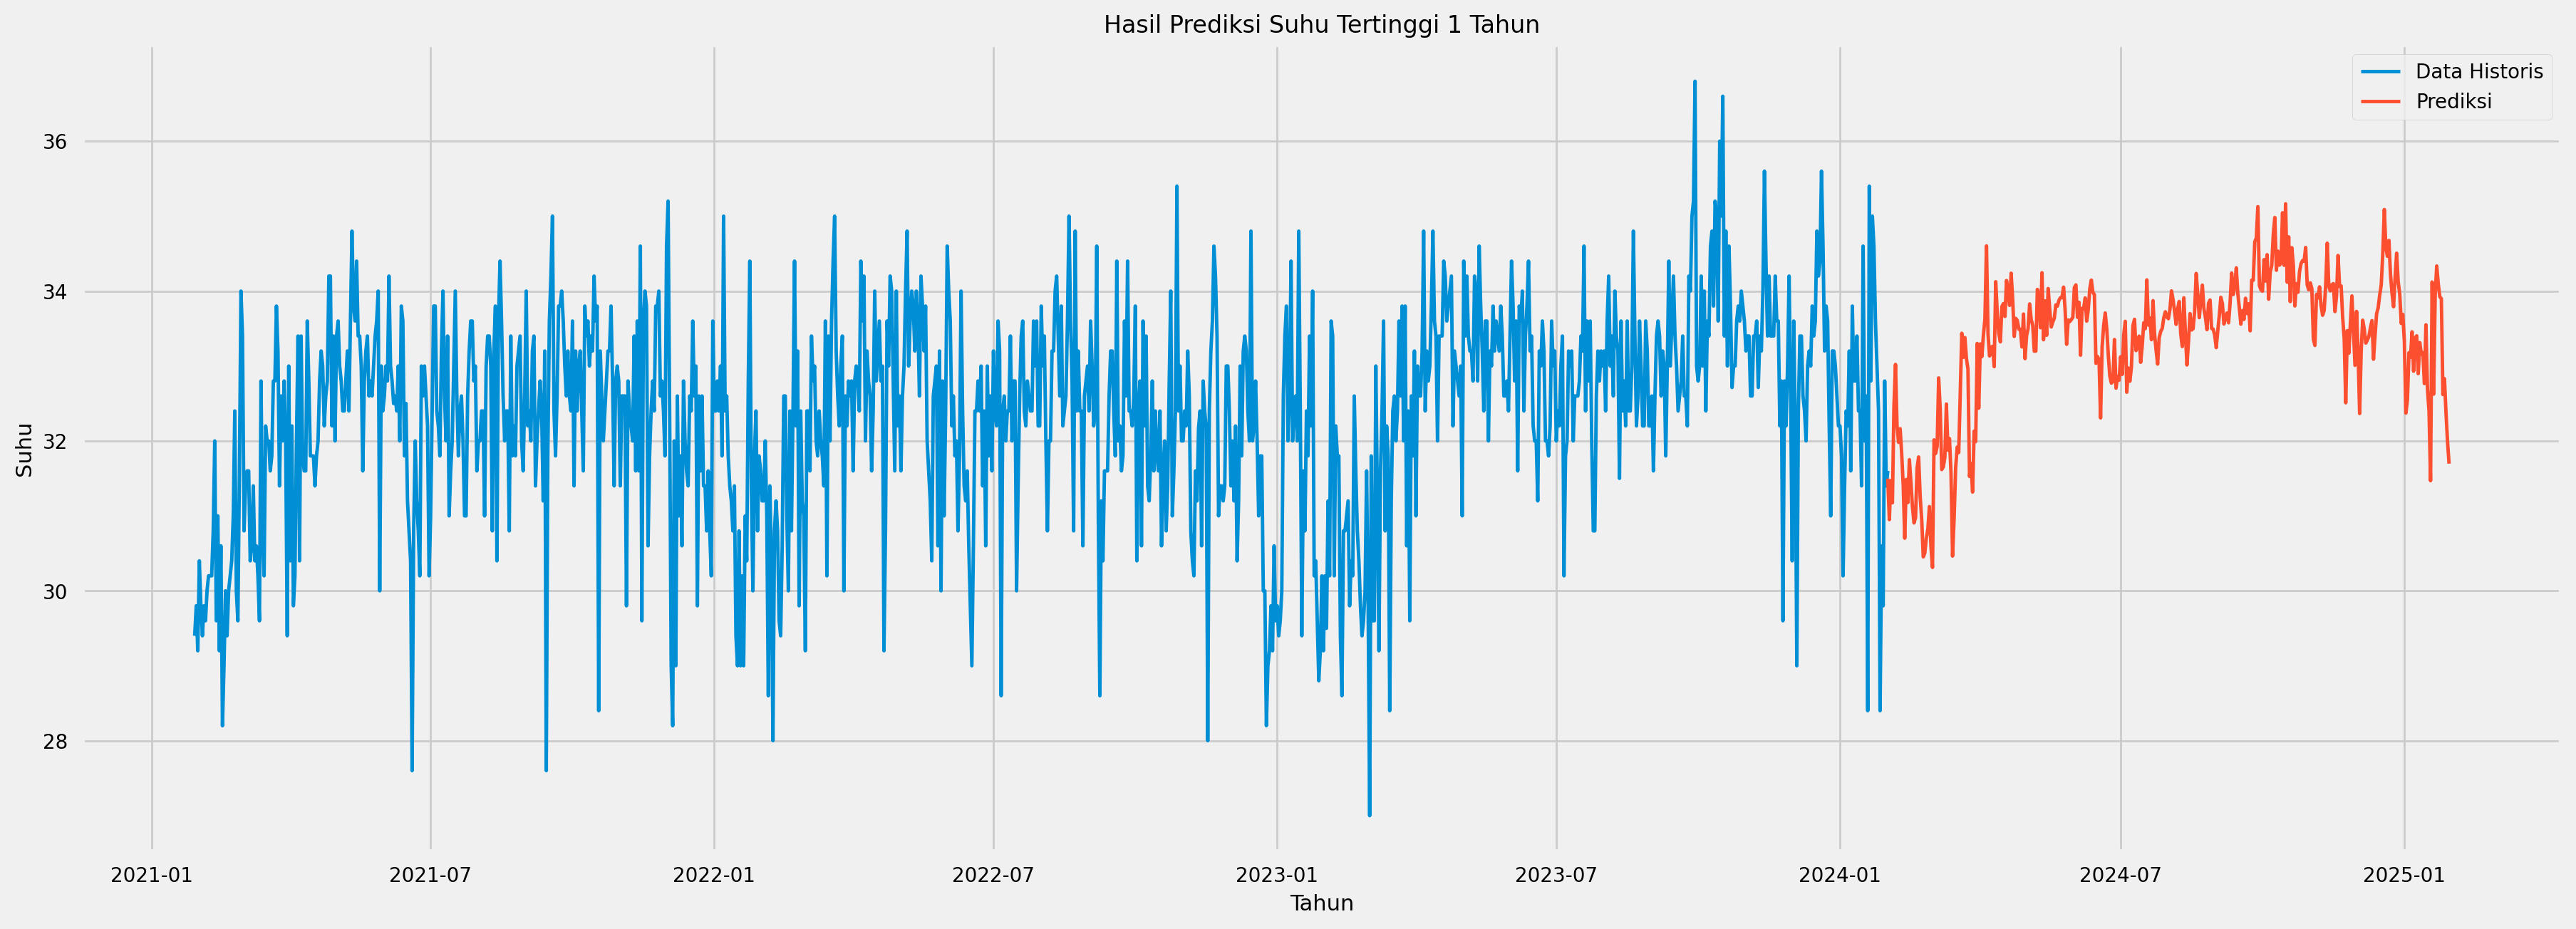

In [48]:
plt.figure(figsize=(20, 7))
plt.plot(climate_data['Tx'][2950:], label='Data Historis')
plt.plot(data_hasil['Prediksi'], label='Prediksi')
plt.title('Hasil Prediksi Suhu Tertinggi 1 Tahun')
plt.xlabel('Tahun')
plt.ylabel('Suhu')
plt.legend()
plt.show()

In [49]:
climate_data.iloc[4017] # untuk menampilkan detail dari data di tanggal 1 Januari 2024

Tn        26.4
Tx        32.2
Tavg      29.6
RH_avg    77.0
RR         1.8
ss         5.6
ff_x       4.0
ff_avg     1.0
Name: 2024-01-01 00:00:00, dtype: float64

In [50]:
data_hasil.iloc[335] # untuk menampilkan detail dari data di tanggal 1 Januari 2025

Prediksi    33.333042
Name: 2025-01-01 00:00:00, dtype: float32

In [51]:
data_hasil.describe()

Prediksi
count  365.000000
mean    33.347294
std      0.929462
min     30.311998
25%     33.098083
50%     33.568478
75%     33.935390
max     35.164722

In [52]:
climate_data['Tx'].describe()

count    4049.000000
mean       32.325109
std         1.540516
min        23.800000
25%        31.600000
50%        32.415186
75%        33.400000
max        37.000000
Name: Tx, dtype: float64

## Perhitungan Anomali atau Selisih Kenaikkan Suhu

In [53]:
mean_asli = climate_data['Tx'].mean() # mengambil nilai rata-rata dari kolom "Suhu tertinggi"
mean_prediksi = data_hasil['Prediksi'].mean() # mengambil nilai rata-rata dari kolom "Prediksi"
anomali_suhu_hari = data_hasil['Prediksi'].iloc[335] - climate_data['Tx'].iloc[4017]
anomali_suhu_rata_rata = mean_prediksi - mean_asli

print(f'Avg Suhu Tertinggi: {round(mean_asli, 2)}')
print(f'Avg Suhu Tertinggi Prediksi: {round(mean_prediksi, 2)} \n')

print(f'Selisih Suhu tanggal (2024-01-01 dan 2025-01-01): \n{round(anomali_suhu_hari, 2)} Derajat Celcius \n')
print(f'Selisih Kenaikan Suhu Tertinggi rata-rata selama 1 tahun (2024 - 2025): \n{round(anomali_suhu_rata_rata, 2)} Derajat Celcius')

Avg Suhu Tertinggi: 32.33
Avg Suhu Tertinggi Prediksi: 33.349998474121094 

Selisih Suhu tanggal (2024-01-01 dan 2025-01-01): 
1.13 Derajat Celcius 

Selisih Kenaikan Suhu Tertinggi rata-rata selama 1 tahun (2024 - 2025): 
1.02 Derajat Celcius


In [54]:
selisih = pd.DataFrame(data=[[mean_prediksi, mean_asli, anomali_suhu_rata_rata]], 
                       columns=['Tx_avg_prediksi', 'Tx_avg', 'Selisih / Anomali'])

print('Tabel Anomali atau Selisih kenaikkan Suhu: ')
selisih

Tabel Anomali atau Selisih kenaikkan Suhu: 


Tx_avg_prediksi     Tx_avg  Selisih / Anomali
0        33.347294  32.325109           1.022184

# Evaluasi Model LSTM

### Evaluasi Kinerja Pelatihan Model

In [55]:
evaluasi_latih = model.predict(trainX)

#denormaliasi
evaluasi_latih_copies = np.repeat(evaluasi_latih, trainX.shape[2], axis=-1)
evaluasi_latih = scaler.inverse_transform(evaluasi_latih_copies)[:,0]
trainY = np.repeat(trainY, trainX.shape[2], axis=-1)
trainY = scaler.inverse_transform(trainY)[:,0]

# membuat tabel untuk hasil denormalisasi
dataX = pd.DataFrame(trainY, columns=['Aktual'])
dataX['Prediksi'] = evaluasi_latih
dataX

114/114 [==============================] - 0s 4ms/step


Aktual   Prediksi
0     31.603030  31.732157
1     30.712121  31.447561
2     29.821212  31.482254
3     30.415152  31.466911
4     33.236364  31.923897
...         ...        ...
3625  33.087879  33.371571
3626  32.345455  33.248055
3627  32.939394  32.933216
3628  32.939394  32.830330
3629  31.603030  32.992538

[3630 rows x 2 columns]

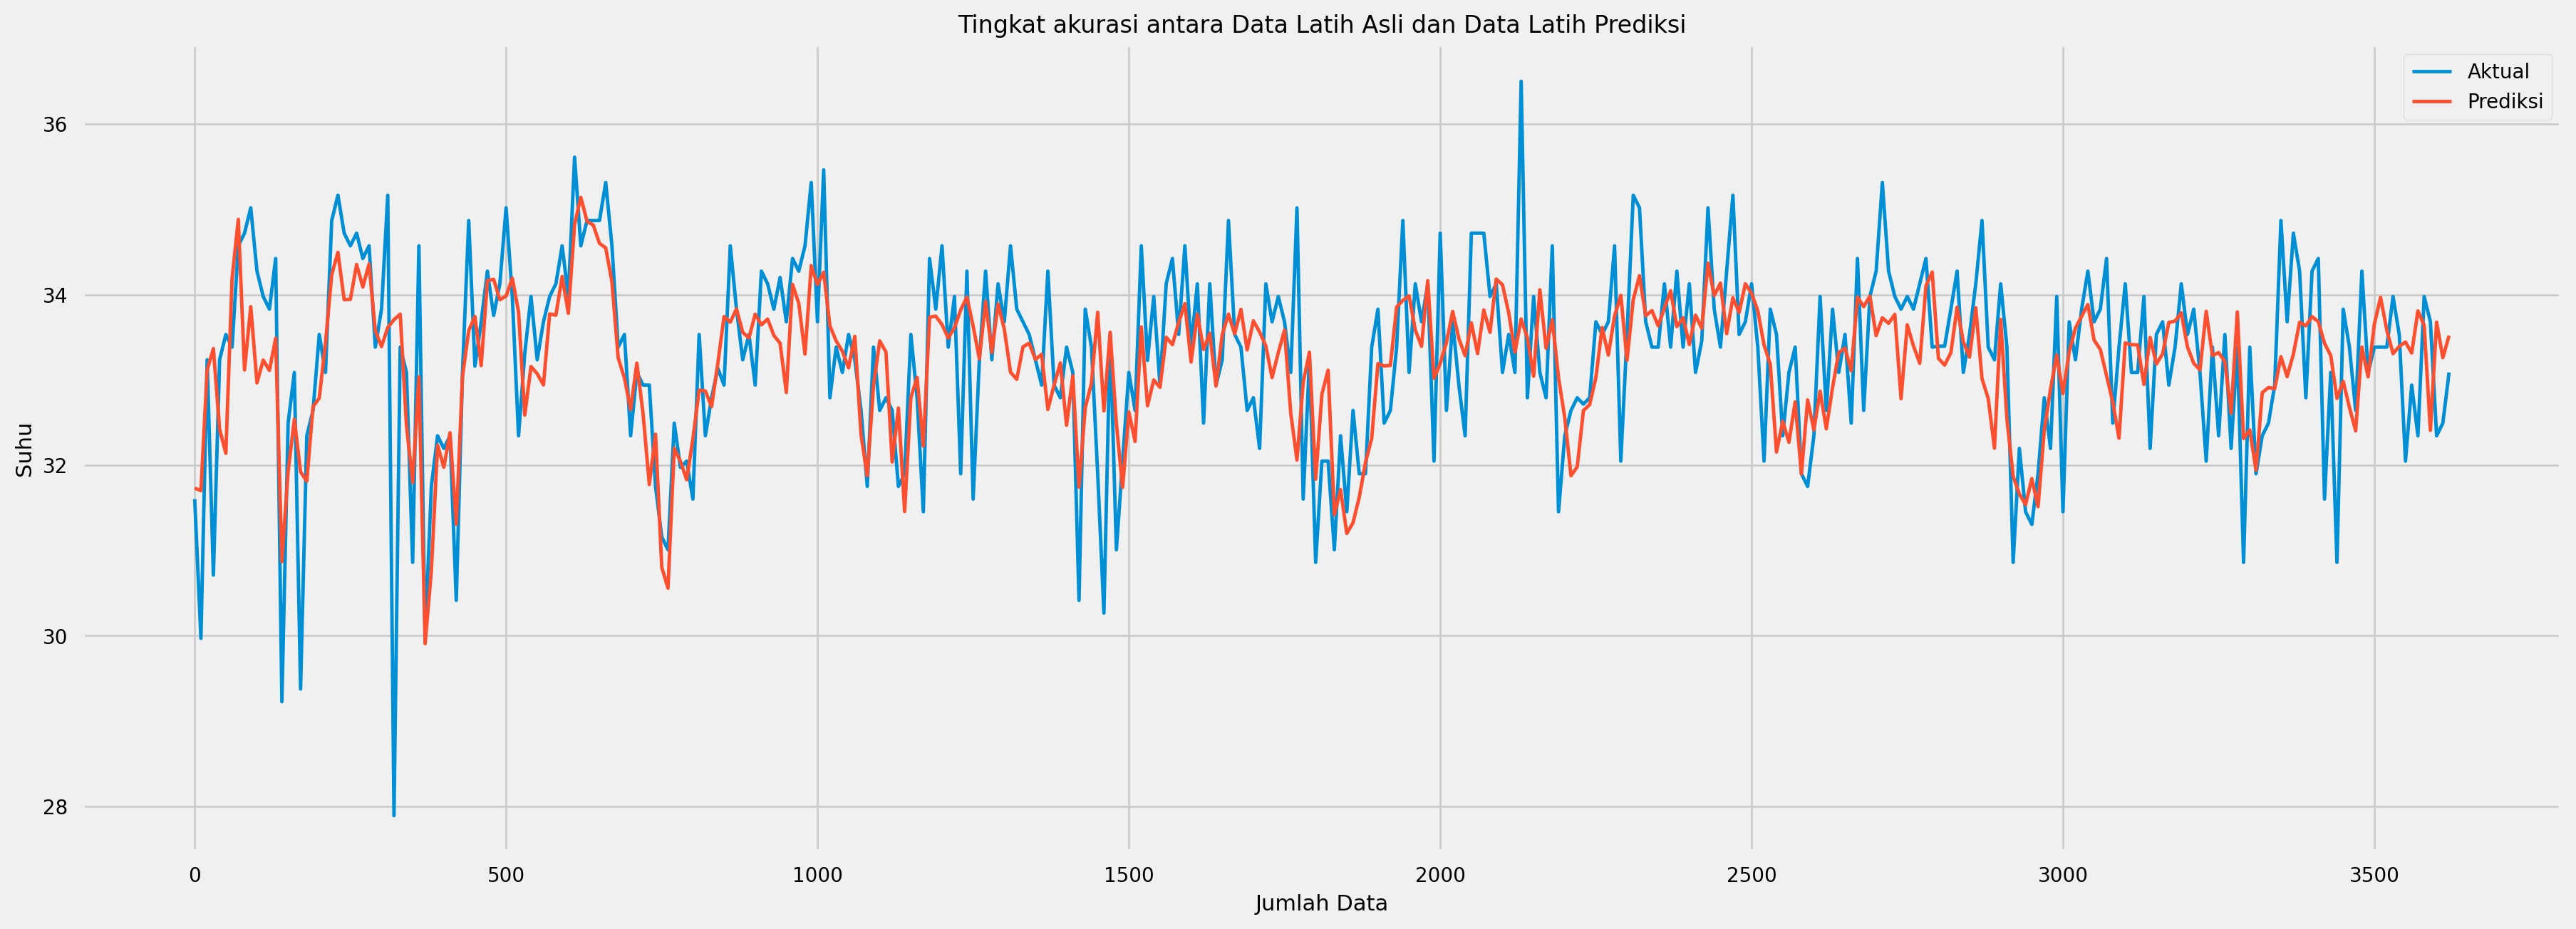

In [56]:
plt.figure(figsize= (20,7))
plt.title('Tingkat akurasi antara Data Latih Asli dan Data Latih Prediksi')
plt.plot(dataX['Aktual'][::10], label='Aktual')
plt.plot(dataX['Prediksi'][::10], label='Prediksi')
plt.xlabel('Jumlah Data')
plt.ylabel('Suhu')
plt.legend()
plt.show()

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(trainY, evaluasi_latih)
mse = mean_squared_error(trainY, evaluasi_latih)
mae = mean_absolute_error(trainY, evaluasi_latih)
rmse = np.sqrt(mse)

print(f'MAE = {round(mae, 4)}')
print(f'MAPE = {round(mape, 2)}% \n')
print(f"RMSE = {round(rmse, 4)}")

MAE = 0.6626
MAPE = 2.0% 

RMSE = 0.879


### Evaluasi Kinerja Pengujian Model

In [58]:
evaluasi_uji = model.predict(testX)

# Denormalisasi
evaluasi_uji_copies = np.repeat(evaluasi_uji, testX.shape[2], axis=-1)
evaluasi_uji = scaler.inverse_transform(evaluasi_uji_copies)[:,0]
testY = np.repeat(testY, testX.shape[2], axis=-1)
testY = scaler.inverse_transform(testY)[:,0]

# membuat tabel untuk hasil denormalisasi
dataY = pd.DataFrame(testY, columns=['Aktual'])
dataY['Prediksi'] = evaluasi_uji
dataY

13/13 [==============================] - 0s 4ms/step


Aktual   Prediksi
0      33.8  32.739601
1      32.0  32.889210
2      32.6  32.199753
3      34.4  32.143230
4      32.0  33.060688
..      ...        ...
386    30.6  32.619511
387    29.8  32.831226
388    32.8  32.380615
389    31.4  31.990448
390    31.6  31.696417

[391 rows x 2 columns]

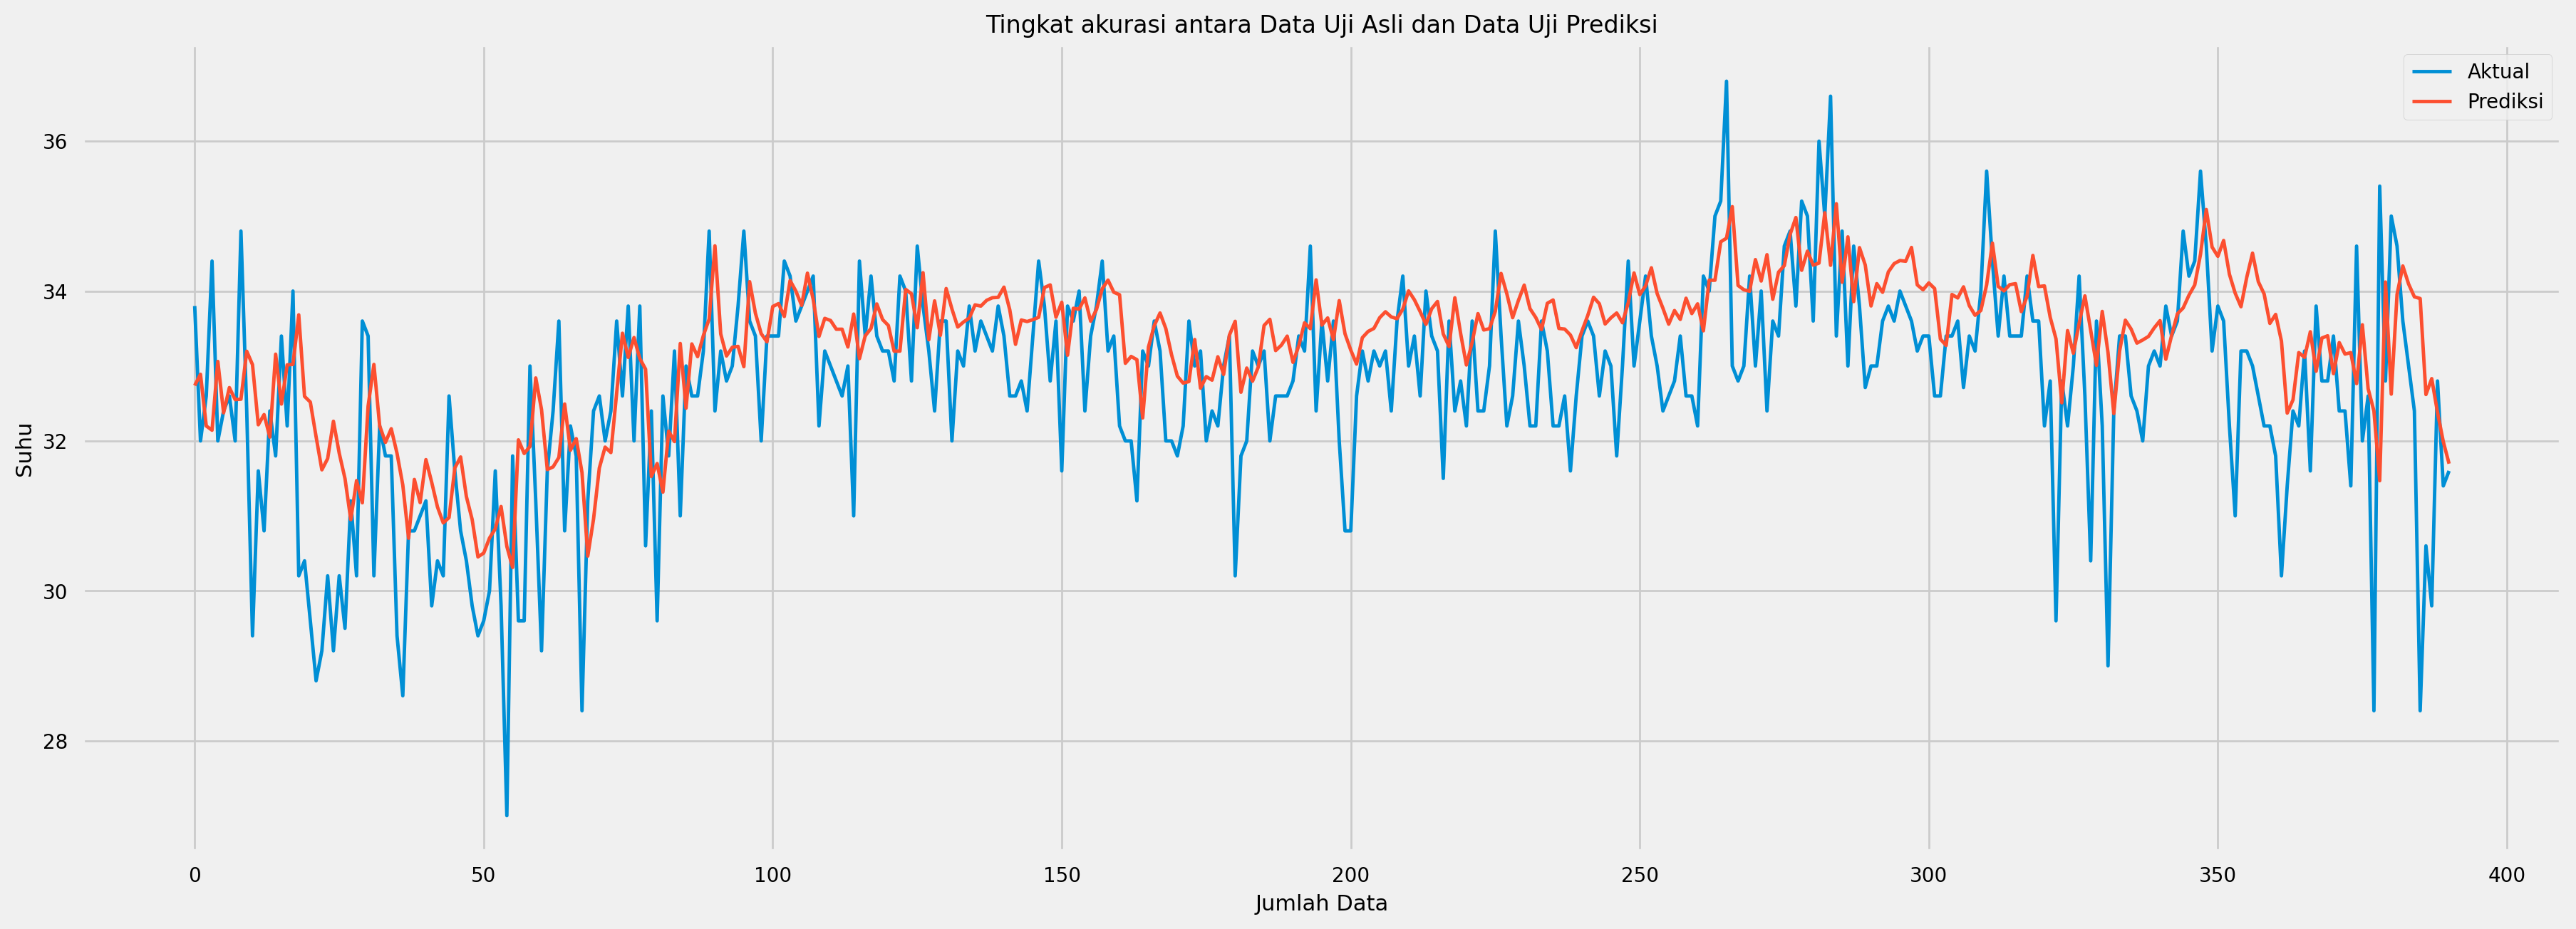

In [59]:
plt.figure(figsize= (20,7))
plt.title('Tingkat akurasi antara Data Uji Asli dan Data Uji Prediksi')
plt.plot(dataY['Aktual'], label='Aktual')
plt.plot(dataY['Prediksi'], label='Prediksi')
plt.xlabel('Jumlah Data')
plt.ylabel('Suhu')
plt.legend()
plt.show()

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(testY, evaluasi_uji)
mae = mean_absolute_error(testY, evaluasi_uji)
mse = mean_squared_error(testY, evaluasi_uji)
rmse = np.sqrt(mse)


print(f'MAE = {round(mae, 4)}')
print(f'MAPE = {round(mape, 2)}% \n')
print(f"RMSE = {round(rmse, 4)}")

MAE = 0.9876
MAPE = 3.09% 

RMSE = 1.2962


# Model Export

In [64]:
# jika kamu mengunakan keras versi == 2.10
# model.save(f'model/lstm-2.10-juni-{n_past}-{round(mape, 2)}.h5')

# jika kamu menggunakan keras versi >= 3.3.*
# model.save(f'model/lstm-2.10-juni-{n_past}-{round(mape, 2)}.keras')

# Excel Export

### Data siap latih

In [62]:
# dataset.to_excel('dataset.xlsx')

# data_untuk_dilatih.to_excel('data_untuk_dilatih.xlsx')
# data_untuk_ditest.to_excel('data_untuk_ditest.xlsx')

# data_untuk_dilatih_scaled = pd.DataFrame(data_untuk_dilatih_scaled)
# data_untuk_ditest_scaled = pd.DataFrame(data_untuk_ditest_scaled)

# data_untuk_dilatih_scaled.to_excel('data_untuk_dilatih_scaled.xlsx')
# data_untuk_ditest_scaled.to_excel('data_untuk_ditest_scaled.xlsx')

### Data hasil prediksi

In [63]:
# forecast = pd.DataFrame(forecast)
# forecast.to_excel('hasil_prediski_scaled.xlsx')
# data_hasil.to_excel('data_hasil.xlsx')

# dataX.to_excel('evaluasi_latih.xlsx')
# dataY.to_excel('evaluasi_uji.xlsx')